In [1]:
from __future__ import unicode_literals
import sys, glob, copy, re
import os, pprint
from os import path
import yaml
import numpy as NP
import numpy.ma as MA
from astropy.io import ascii
from astropy.table import Table, Column
from uncertainties import ufloat, unumpy
import matplotlib.pyplot as PLT
from matplotlib.ticker import FormatStrFormatter, LogLocator, NullFormatter
from IPython.core.debugger import set_trace
%matplotlib notebook

import derive_PSRparms
sys.path.append('..')
from mass_constraints import derive_combined_mass
sys.path.append('../tableScripts')
import readParFile
os.environ["PATH"] += os.pathsep + '/usr/bin/'
PLT.rcParams["text.usetex"] = False
from matplotlib import rc
rc('text', usetex=True)
rc('text.latex',unicode=True)

# font = {'family' : 'serif',
#         'weight' : 'medium',
#         'size'   : 12,
#         'serif'  : ['Computer Modern']}
# rc('font', **font)
rc('font', **{'size': 14,'family': 'serif', 'serif': ['Computer Modern']})

Odering of arguments in all functions in GalDynPsr is very important. Consult the README.md (online) or the README.txt file residing in the installation directory
/fred/oz002/nthyagar/src/miniconda3/envs/PTA/lib/python3.7/site-packages/ipykernel_launcher.py:25: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 3.0 and will be removed in 3.2.



## Read input file containing parameters for the script

In [2]:
parmsfile = './PSR_comparison_parms.yaml'
# parmsfile = '/fred/oz002/nthyagar/codes/mine/python/projects/dr2e/PSR_comparison/PSR_comparison_parms.yaml'
with open(parmsfile, 'r') as pfile:
    parms = yaml.safe_load(pfile)
    
projectdir = parms['dirstruct']['projectdir']
PTA_datadir = projectdir + parms['dirstruct']['PTA_data_dir']
outdir = projectdir + parms['dirstruct']['outdir']
figdir = outdir + parms['dirstruct']['figdir']
pta_dir_info = parms['dirstruct']['PTA_dirinfo']

In [3]:
print(pta_dir_info)

{'EPTA-DR1': {'PSRdir': '/fred/oz002/nthyagar/projects/dr2_ephemerides/PTA_DataReleases/eptaDR1/EPTA_v2.2_git/'}, 'NG-11yr': {'PSRdir': '/fred/oz002/nthyagar/projects/dr2_ephemerides/PTA_DataReleases/NANOGrav_11y/par/'}, 'NG-12.5yr-NB': {'PSRdir': '/fred/oz002/nthyagar/projects/dr2_ephemerides/PTA_DataReleases/NANOGrav_12yv3/narrowband/par/'}, 'NG-12.5yr-WB': {'PSRdir': '/fred/oz002/nthyagar/projects/dr2_ephemerides/PTA_DataReleases/NANOGrav_12yv3/wideband/par/'}, 'PPTA-DR1': {'PSRdir': '/fred/oz002/nthyagar/projects/dr2_ephemerides/PTA_DataReleases/ppta15/'}, 'PPTA-DR2O': {'PSRdir': '/fred/oz002/dreardon/ppta_dr2_ephemerides/publish_collection_refit/dr2/ecliptic/'}, 'PPTA-DR2E': {'PSRdir': '/fred/oz002/dreardon/ppta_dr2_ephemerides/publish_collection_refit/dr2e/ecliptic/'}, 'PPTA-DR2': {'PSRdir': '../final/tempo2/'}}


## Parse standard and specific (with variation) pulsar names in each PTA

In [15]:
pta_info = {}
for pta in pta_dir_info:
    pta_info[pta] = {'PSRdir': pta_dir_info[pta]['PSRdir']}
    if pta == 'EPTA-DR1':
        path_to_parfile_names = glob.glob(pta_dir_info[pta]['PSRdir']+'*')
        pta_info[pta]['PSRnames_simple'] = [fname_str.split('/')[-1] for fname_str in path_to_parfile_names]
        pta_info[pta]['PSRnames_specific'] = pta_info[pta]['PSRnames_simple']
    else:
        path_to_parfile_names = glob.glob(pta_dir_info[pta]['PSRdir']+'*.par')
        if 'PPTA' in pta:
            if pta == 'PPTA_DR1':
                pta_info[pta]['PSRnames_simple'] = [fname_str.split('/')[-1].split('.')[0] for fname_str in path_to_parfile_names]
                pta_info[pta]['PSRnames_specific'] = [fname_str.split('/')[-1].split('.par')[0] for fname_str in path_to_parfile_names]
            else:
                if 'ecliptic' in pta_dir_info[pta]['PSRdir']:
                    pta_info[pta]['PSRnames_simple'] = [re.split('[_.]', fname_str.split('/')[-1])[0] for fname_str in path_to_parfile_names]
                    pta_info[pta]['PSRnames_specific'] = [fname_str.split('/')[-1].split('_ecliptic.par')[0] for fname_str in path_to_parfile_names]                
    #                 pta_info[pta]['PSRnames_simple'] = [fname_str.split('/')[-1].split('_')[0] for fname_str in path_to_parfile_names]
    #                 pta_info[pta]['PSRnames_specific'] = [fname_str.split('/')[-1].split('_ecliptic.par')[0] for fname_str in path_to_parfile_names]                
                else:
                    pta_info[pta]['PSRnames_simple'] = [re.split('[_.]', fname_str.split('/')[-1])[0] for fname_str in path_to_parfile_names]
                    pta_info[pta]['PSRnames_specific'] = [fname_str.split('/')[-1].split('.par')[0] for fname_str in path_to_parfile_names]                                    
        else:
            pta_info[pta]['PSRnames_simple'] = [fname_str.split('/')[-1].split('_',1)[0] for fname_str in path_to_parfile_names]
            pta_info[pta]['PSRnames_specific'] = copy.deepcopy(pta_info[pta]['PSRnames_simple'])
            for ind,fname_str in enumerate(path_to_parfile_names):
                if fname_str.split('/')[-1].split('.')[-2] != 'gls':
                    append_str = fname_str.split('/')[-1].split('.')[-2]
                    pta_info[pta]['PSRnames_specific'][ind] = pta_info[pta]['PSRnames_simple'][ind] + '.' + append_str

In [16]:
print(pta_info)

{'EPTA-DR1': {'PSRdir': '/fred/oz002/nthyagar/projects/dr2_ephemerides/PTA_DataReleases/eptaDR1/EPTA_v2.2_git/', 'PSRnames_simple': ['J1022+1001', 'J1801-1417', 'J1804-2717', 'J1955+2908', 'J1738+0333', 'J0034-0534', 'J1910+1256', 'J2019+2425', 'J2010-1323', 'J0610-2100', 'J1713+0747', 'J1640+2224', 'J1909-3744', 'J2124-3358', 'J2322+2057', 'J0218+4232', 'J2033+1734', 'J1911-1114', 'J1455-3330', 'J1857+0943', 'J0751+1807', 'J1721-2457', 'J1918-0642', 'J1024-0719', 'J1911+1347', 'J0613-0200', 'J1643-1224', 'J2229+2643', 'J1730-2304', 'J1853+1303', 'J2317+1439', 'J1939+2134', 'J1012+5307', 'J2145-0750', 'J0621+1002', 'J1600-3053', 'J1802-2124', 'J1744-1134', 'J0030+0451', 'J0900-3144', 'J1751-2857', 'J1843-1113'], 'PSRnames_specific': ['J1022+1001', 'J1801-1417', 'J1804-2717', 'J1955+2908', 'J1738+0333', 'J0034-0534', 'J1910+1256', 'J2019+2425', 'J2010-1323', 'J0610-2100', 'J1713+0747', 'J1640+2224', 'J1909-3744', 'J2124-3358', 'J2322+2057', 'J0218+4232', 'J2033+1734', 'J1911-1114', 'J14

## Create a sorted union of pulsar names

In [17]:
psrnames_simple_union = []
psrnames_specific_union = []
for pta in pta_dir_info:
    psrnames_simple_union += pta_info[pta]['PSRnames_simple']
    psrnames_specific_union += pta_info[pta]['PSRnames_specific']
psrnames_simple_union = NP.asarray(list(set(psrnames_simple_union)))
psrnames_specific_union = NP.asarray(list(set(psrnames_specific_union)))

## Sort these pulsars by RA/Dec

psrnames_simple_union = sorted(psrnames_simple_union, key=lambda x: ((int(x[1:5]), int(x[5:10])))) # Sort by RA-key and then by Dec-key
psrnames_specific_union = sorted(psrnames_specific_union, key=lambda x: ((x[1:5], x[5:10]))) # Sort by RA-key and then by Dec-key

## Populate the Numpy array with parameter values along with uncertainties from all PTA for all pulsars

In [18]:
compare_parms = parms['compareParms']
psr_parms = compare_parms['params']
ptas = NP.asarray(compare_parms['PTA'])
# pta_psr_parm_vals = {parm: {} for parm in psr_parms}
pta_psr_parm_uvals = {parm: {} for parm in psr_parms}
pta_psr_parm_uvals_diff = {parm: {} for parm in psr_parms}
pta_psr_parm_uvals_fracdiff = {parm: {} for parm in psr_parms}
# pta_psr_parm_vals_normratio = {parm: {} for parm in psr_parms}
ref_pta = compare_parms['ref_PTA']
ref_pta_ind = ptas.tolist().index(ref_pta)
rest_pta_ind = NP.setdiff1d(NP.arange(ptas.size), ref_pta_ind)
rest_ptas = ptas[rest_pta_ind]
ref_pta_psrs_ind = NP.sort([psrnames_simple_union.index(psrnam) for psrnam in NP.unique(pta_info[ref_pta]['PSRnames_simple'])])
ref_pta_psrs = NP.asarray(psrnames_simple_union)[ref_pta_psrs_ind]

In [19]:
for parm in psr_parms:
    outvals = NP.empty((len(psrnames_simple_union),len(ptas),2), dtype=NP.float128)
    outvals.fill(NP.nan)
    for ptai,pta in enumerate(ptas):
        for psri,psr in enumerate(psrnames_simple_union):
            if psr in pta_info[pta]['PSRnames_simple']:
                if pta == 'EPTA-DR1':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}/{0}.par'.format(psr)
                elif pta == 'NG-11yr':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}_NANOGrav_11yv1.gls.par'.format(psr)
                elif pta == 'NG-12.5yr-NB':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}_NANOGrav_12yv3.gls.par'.format(psr)
                elif pta == 'NG-12.5yr-WB':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}_NANOGrav_12yv3.wb.gls.par'.format(psr)
                elif pta == 'PPTA-DR1':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.par'.format(psr)
                elif (pta == 'PPTA-DR2O') or (pta == 'PPTA-DR2E'):
#                     parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.par'.format(psr)
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}_ecliptic.par'.format(psr)
                    if not path.exists(parfilename):
#                         parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.kop.par'.format(psr)
                        parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.kop_ecliptic.par'.format(psr)
                    if not path.exists(parfilename):
#                         parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.kop_alt.par'.format(psr)                    
                        parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.kop_alt_ecliptic.par'.format(psr)  
                elif pta == 'PPTA-DR2':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.par'.format(psr)                    
                else:
                    raise ValueError('This PTA is either not requested in processing or unavailable in the database.')
                parmdict = readParFile.read_par(parfilename)
                if (parm in parmdict) and (parm+'_ERR' in parmdict):
                    pval = parmdict[parm]
                    pvalerr = parmdict[parm+'_ERR']
                    outvals[psri,ptai,:] = NP.asarray([pval, pvalerr], dtype=NP.float128)
#         pta_psr_parm_vals[parm][pta] = MA.array(outvals[:,ptai,:], mask=NP.isnan(outvals[:,ptai,:]))
        pta_psr_parm_uvals[parm][pta] = unumpy.uarray(outvals[:,ptai,0], outvals[:,ptai,1])
    for ptai,pta in enumerate(ptas):
        pta_psr_parm_uvals_diff[parm][pta] = pta_psr_parm_uvals[parm][pta] - pta_psr_parm_uvals[parm][ref_pta]
        pta_psr_parm_uvals_fracdiff[parm][pta] = pta_psr_parm_uvals[parm][pta] / pta_psr_parm_uvals[parm][ref_pta] - 1
        
#     pta_psr_parm_vals[parm]['all'] = MA.array(outvals, mask=NP.isnan(outvals))
    pta_psr_parm_uvals[parm]['all'] = unumpy.uarray(outvals[:,:,0], outvals[:,:,1])
    pta_psr_parm_uvals_diff[parm]['all'] = pta_psr_parm_uvals[parm]['all'] - pta_psr_parm_uvals[parm]['all'][:,[ref_pta_ind]]
    pta_psr_parm_uvals_fracdiff[parm]['all'] = pta_psr_parm_uvals[parm]['all'] / pta_psr_parm_uvals[parm]['all'][:,[ref_pta_ind]] - 1
#     vals_normratio = NP.zeros((len(psrnames_simple_union),len(ptas),2), dtype=NP.float128)
#     vals_normratio[:,:,0] = (outvals[:,:,0] - outvals[:,[ref_pta_ind],0]) / outvals[:,[ref_pta_ind],0]
#     vals_normratio[:,:,1] = outvals[:,:,1] / outvals[:,[ref_pta_ind],1]
#     pta_psr_parm_vals_normratio[parm]['all'] = MA.array(vals_normratio, mask=NP.isnan(vals_normratio))
    
    for psri,psr in enumerate(psrnames_simple_union):
#         pta_psr_parm_vals[parm][psr] = MA.array(outvals[psri,:,:], mask=NP.isnan(outvals[psri,:,:]))
#         pta_psr_parm_vals_normratio[parm][psr] = MA.array(vals_normratio[psri,:,:], mask=NP.isnan(vals_normratio[psri,:,:]))
        pta_psr_parm_uvals[parm][psr] = unumpy.uarray(outvals[psri,:,0], outvals[psri,:,1]) 
        pta_psr_parm_uvals_diff[parm][psr] = pta_psr_parm_uvals_diff[parm]['all'][psri,:]
        pta_psr_parm_uvals_fracdiff[parm][psr] = pta_psr_parm_uvals_fracdiff[parm]['all'][psri,:]

In [20]:
print('All pulsars [Simple Names]\n--------------------------')
print(psrnames_simple_union)
print('\nAll pulsars [Specific Names]\n----------------------------')
print(psrnames_specific_union)
print('\nReference PTA ({0}) pulsars [Simple Names]\n-----------------------------------------------'.format(ref_pta))
print(ref_pta_psrs)

All pulsars [Simple Names]
--------------------------
['J0023+0923', 'J0030+0451', 'J0034-0534', 'J0218+4232', 'J0340+4130', 'J0437-4715', 'J0610-2100', 'J0613-0200', 'J0621+1002', 'J0636+5128', 'J0645+5158', 'J0711-6830', 'J0740+6620', 'J0751+1807', 'J0900-3144', 'J0931-1902', 'J1012+5307', 'J1017-7156', 'J1022+1001', 'J1024-0719', 'J1045-4509', 'J1125-6014', 'J1125+7819', 'J1446-4701', 'J1453+1902', 'J1455-3330', 'J1545-4550', 'J1600-3053', 'J1603-7202', 'J1614-2230', 'J1640+2224', 'J1643-1224', 'J1713+0747', 'J1721-2457', 'J1730-2304', 'J1732-5049', 'J1738+0333', 'J1741+1351', 'J1744-1134', 'J1747-4036', 'J1751-2857', 'J1801-1417', 'J1802-2124', 'J1804-2717', 'J1824-2452A', 'J1832-0836', 'J1843-1113', 'J1853+1303', 'B1855+09', 'J1857+0943', 'J1903+0327', 'J1909-3744', 'J1910+1256', 'J1911-1114', 'J1911+1347', 'J1918-0642', 'J1923+2515', 'B1937+21', 'J1939+2134', 'J1944+0907', 'J1946+3417', 'B1953+29', 'J1955+2908', 'J2010-1323', 'J2017+0603', 'J2019+2425', 'J2033+1734', 'J2043+1711'

## Compute and store derived PSR parms

/fred/oz002/nthyagar/codes/others/python/PPTA_DR2E/parameterComparisonScripts/derive_PSRparms.py:183: RuntimeWarning: invalid value encountered in arcsin
  inc = NP.arcsin(sini)*180/NP.pi

/fred/oz002/nthyagar/codes/others/python/PPTA_DR2E/parameterComparisonScripts/derive_PSRparms.py:229: RuntimeWarning: invalid value encountered in sqrt
  mp = NP.sqrt(mtot2[is_valid(mtot2)*is_valid(m2)]) - m2[is_valid(mtot2)*is_valid(m2)]



<IPython.core.display.Javascript object>


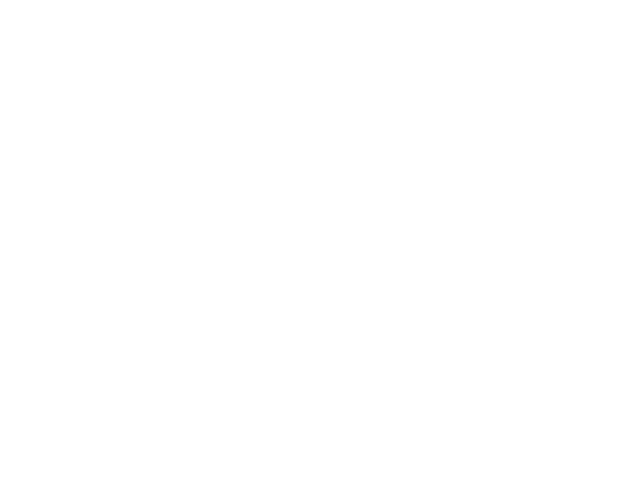

<IPython.core.display.Javascript object>


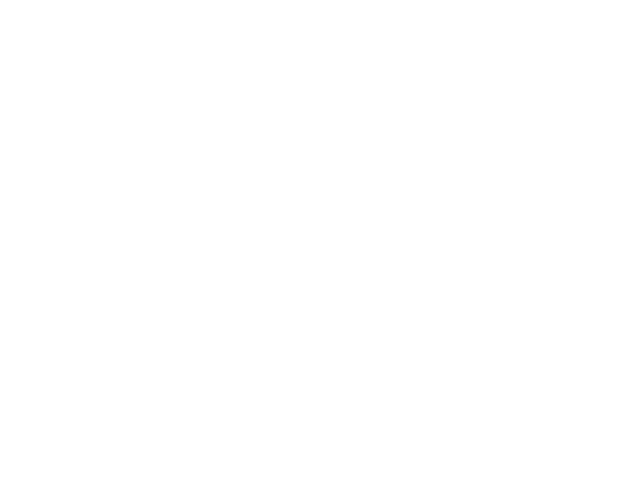

<IPython.core.display.Javascript object>


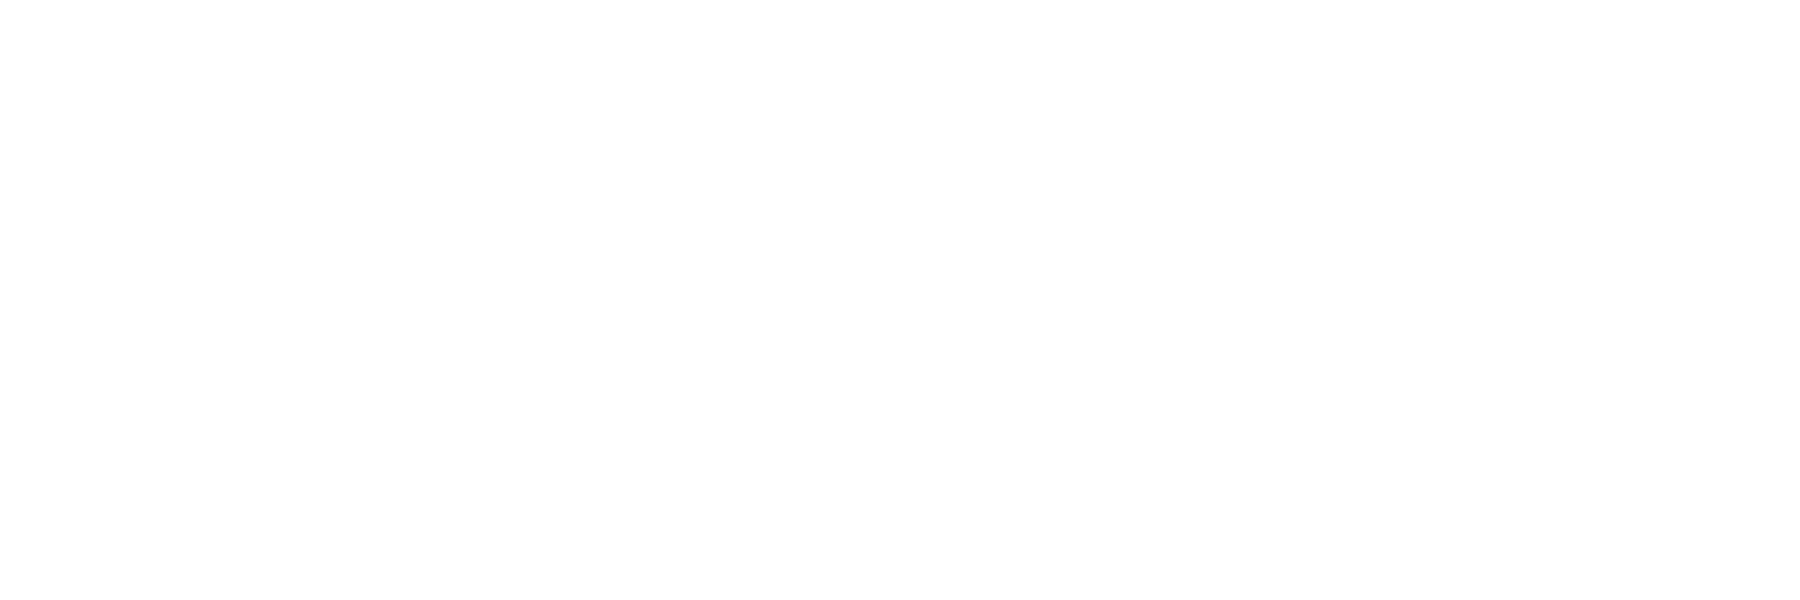

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


<IPython.core.display.Javascript object>


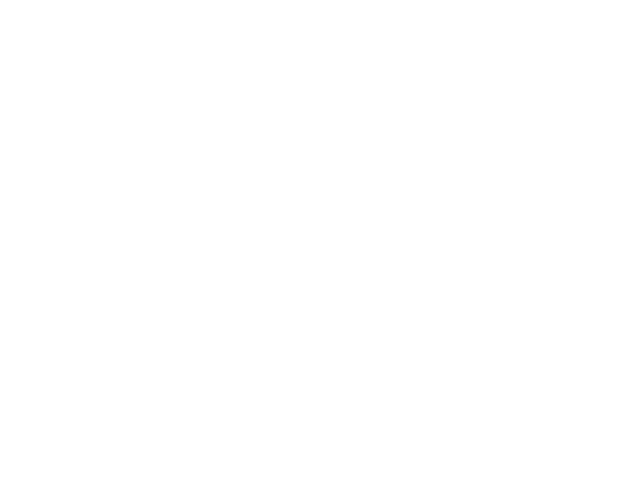

<IPython.core.display.Javascript object>


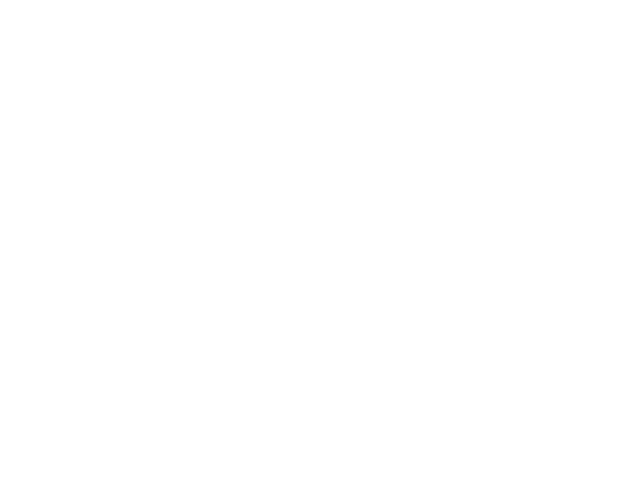

<IPython.core.display.Javascript object>


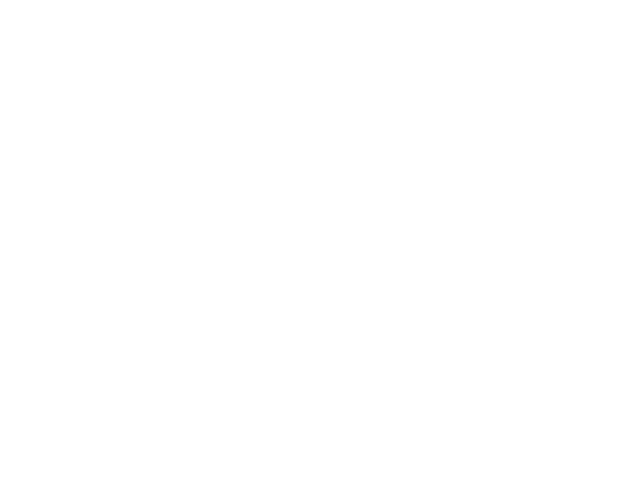

<IPython.core.display.Javascript object>


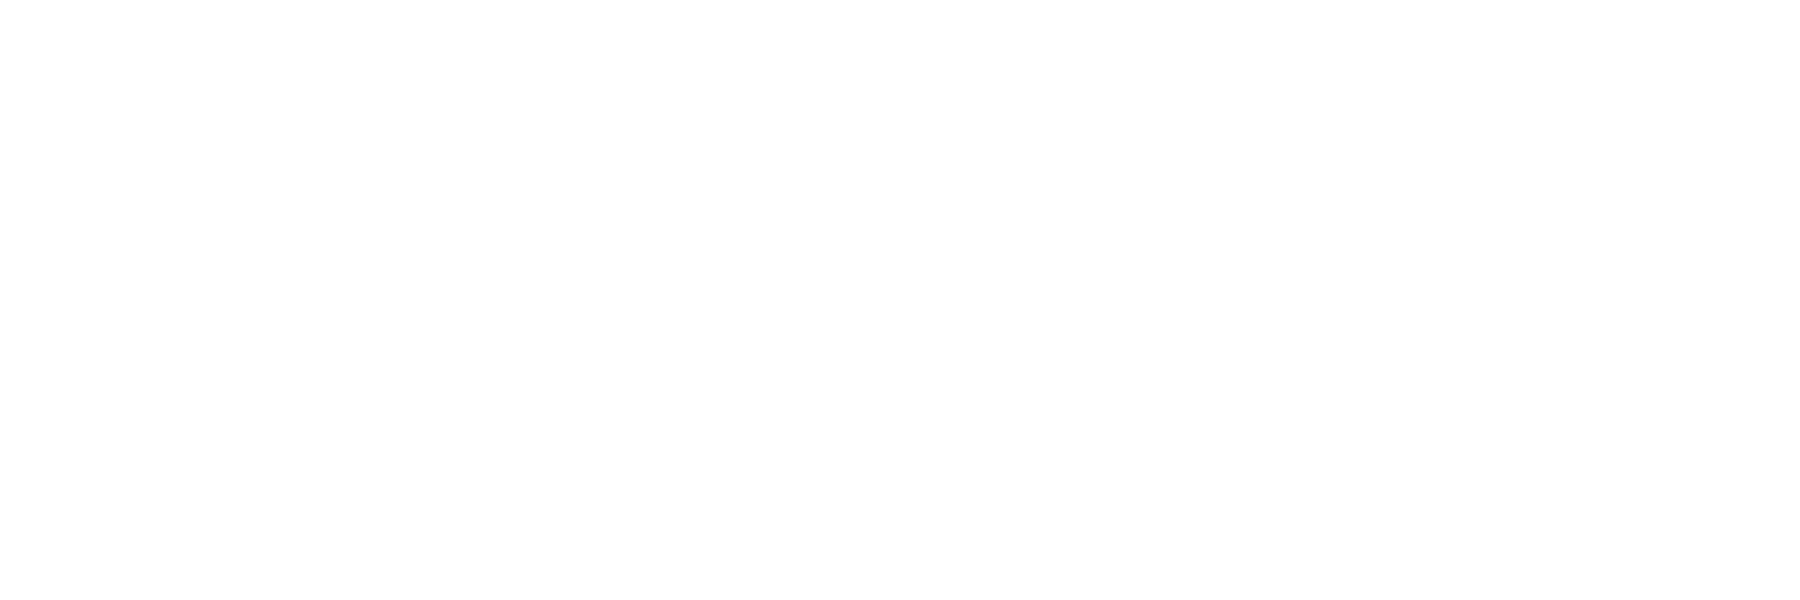

<IPython.core.display.Javascript object>


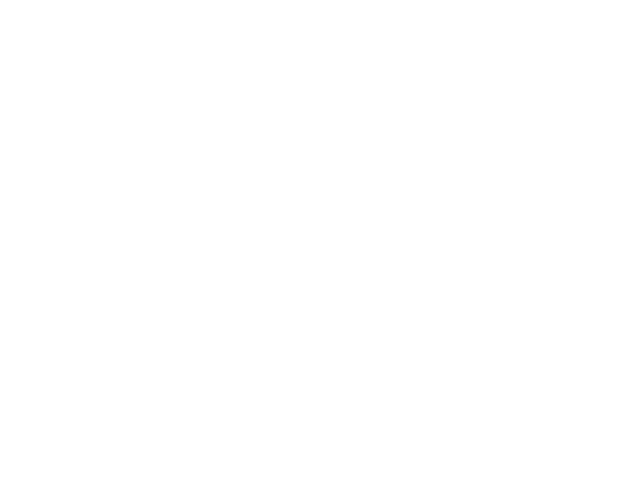

../mass_constraints.py:276: RuntimeWarning: invalid value encountered in sqrt
  mp = np.sqrt(mtot2[is_valid(mtot2)*is_valid(m2)]) - m2[is_valid(mtot2)*is_valid(m2)]



<IPython.core.display.Javascript object>


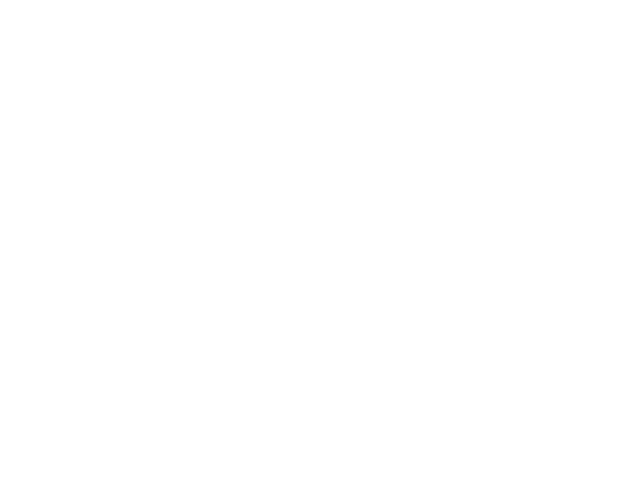

<IPython.core.display.Javascript object>


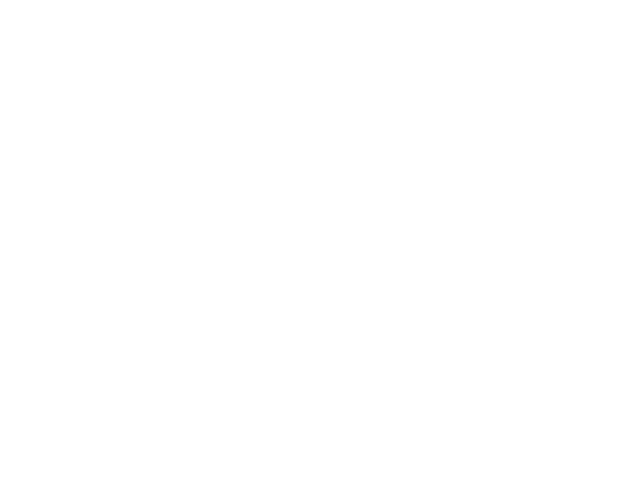

<IPython.core.display.Javascript object>


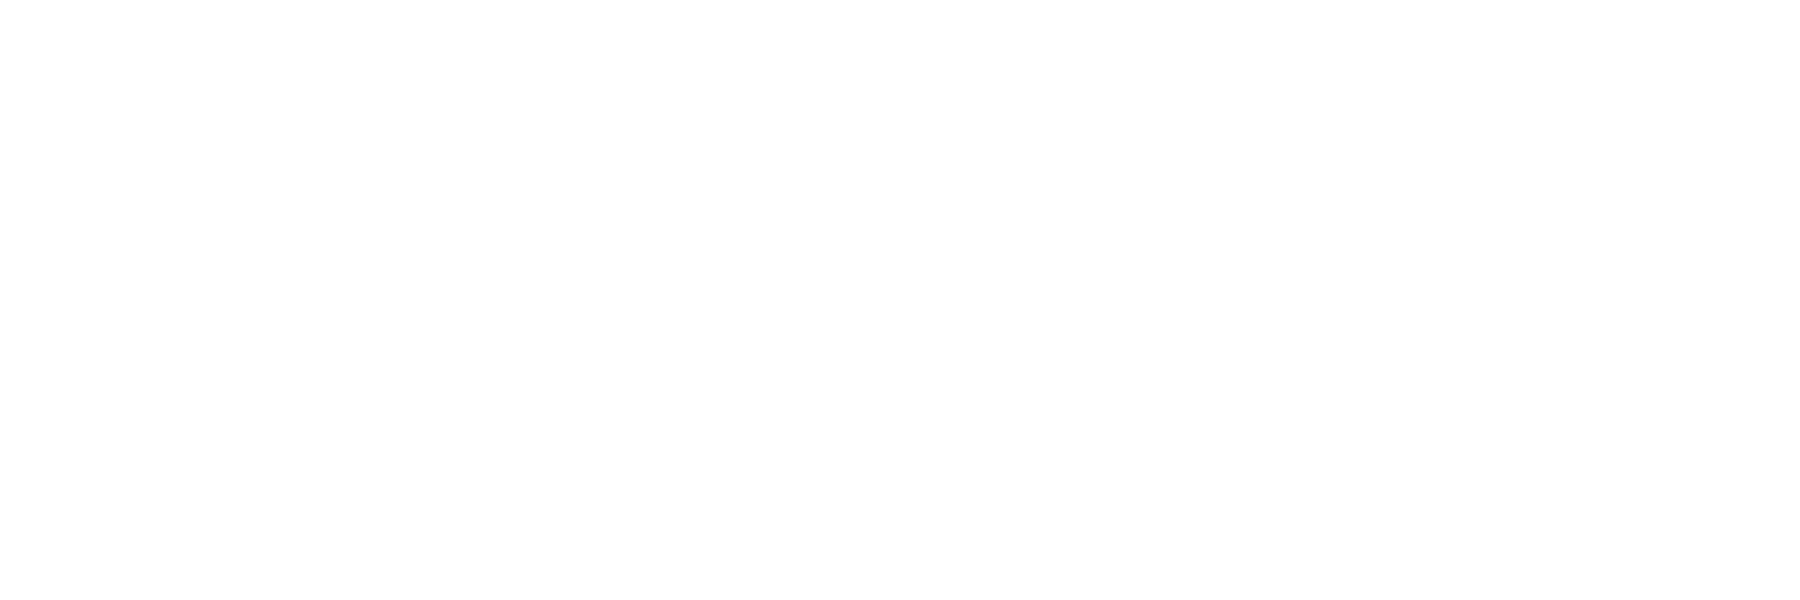

<IPython.core.display.Javascript object>


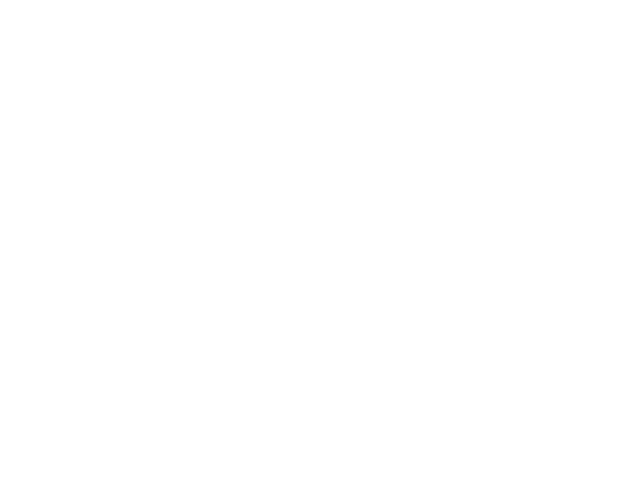

<IPython.core.display.Javascript object>


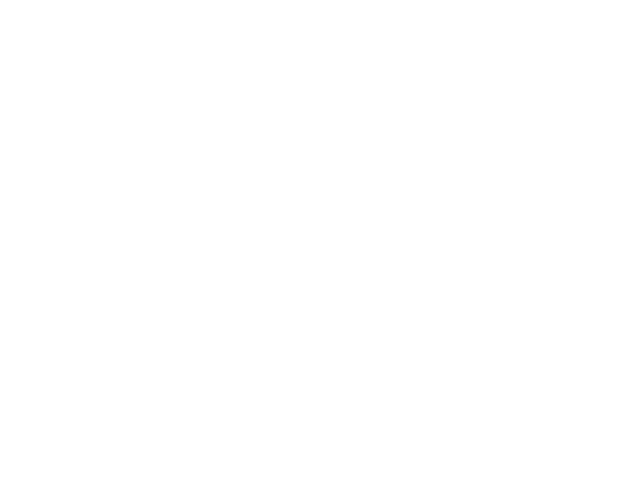

<IPython.core.display.Javascript object>


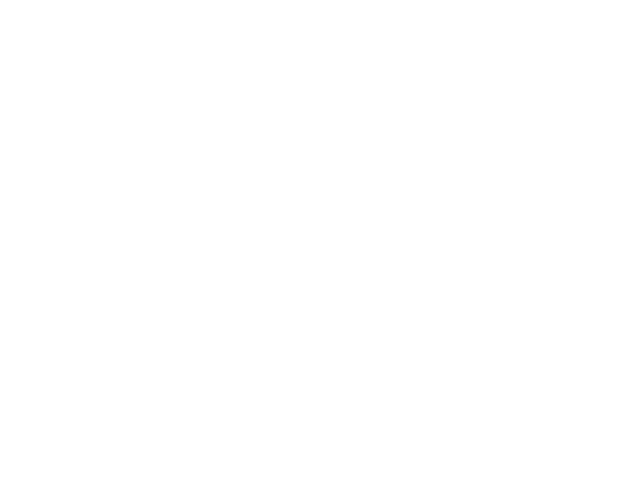

<IPython.core.display.Javascript object>


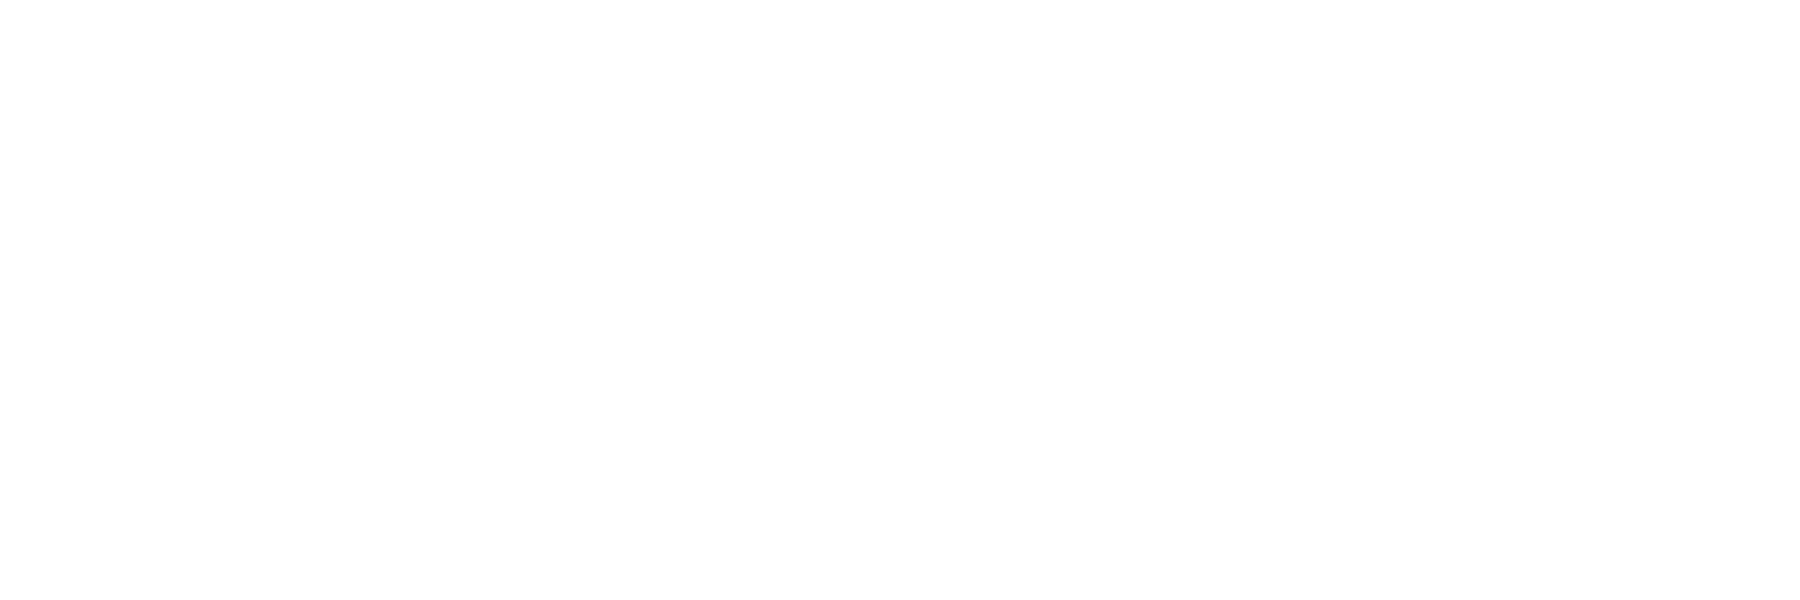

<IPython.core.display.Javascript object>


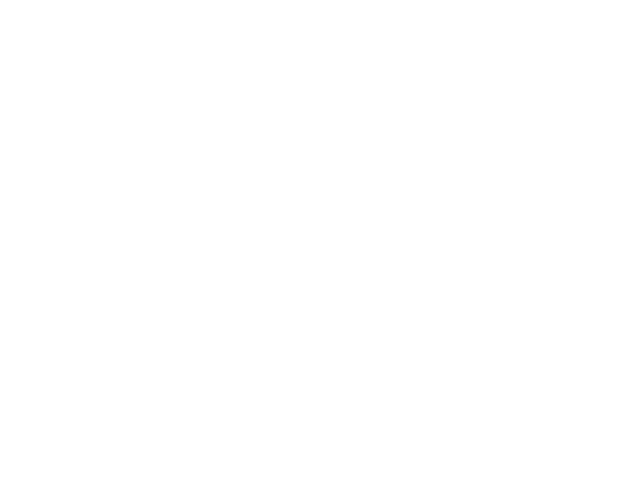

<IPython.core.display.Javascript object>


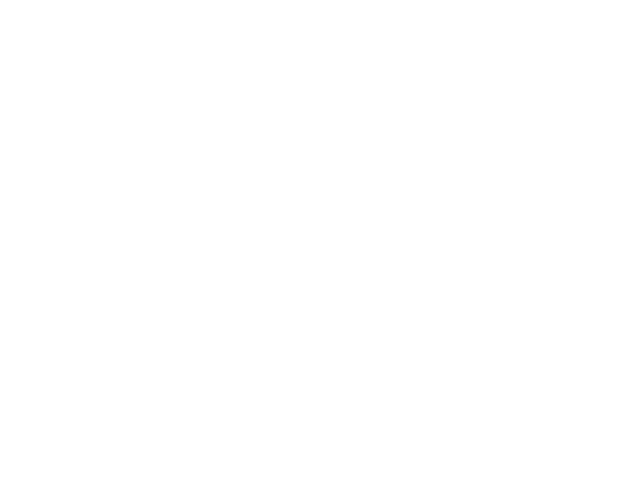

<IPython.core.display.Javascript object>


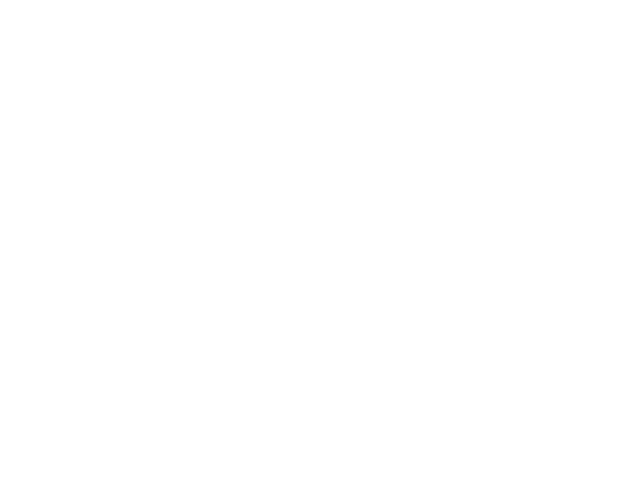

<IPython.core.display.Javascript object>


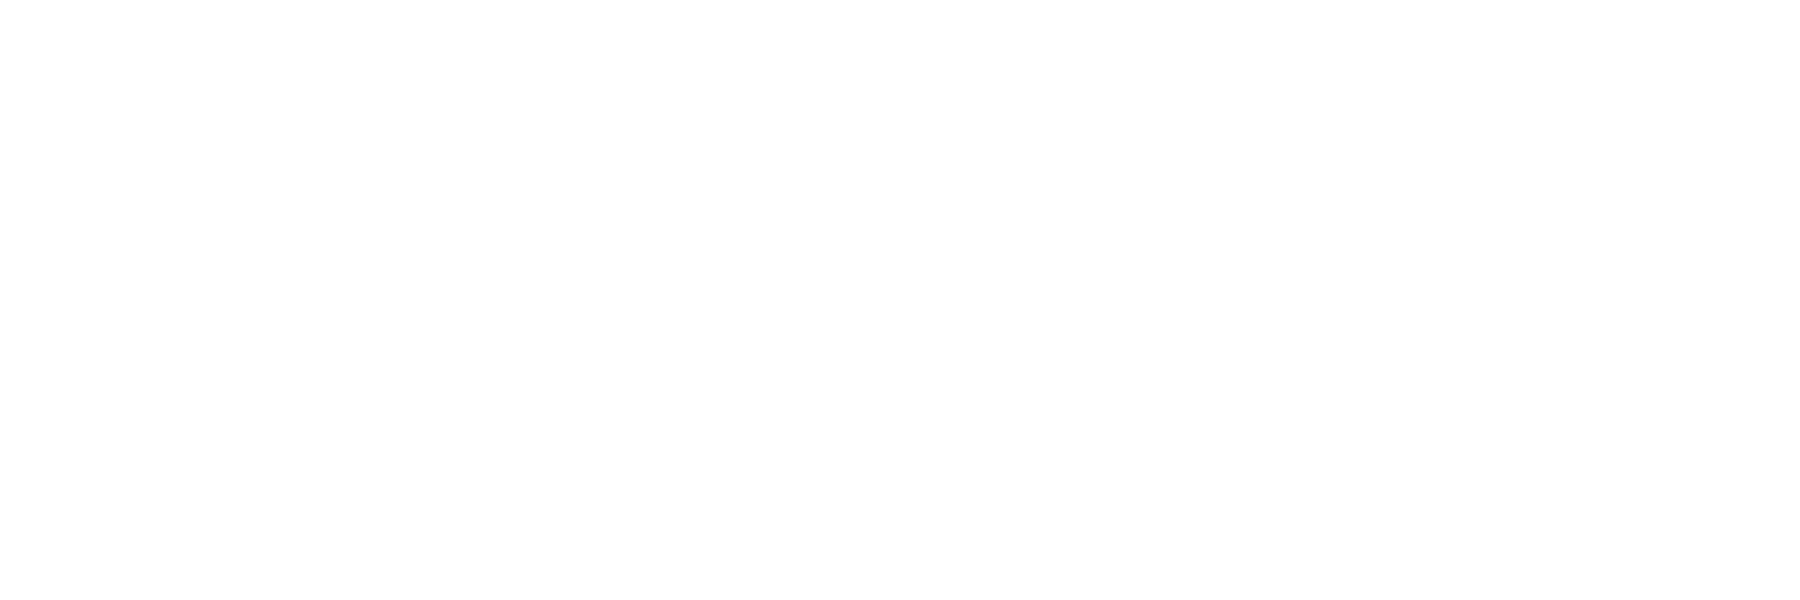

<IPython.core.display.Javascript object>


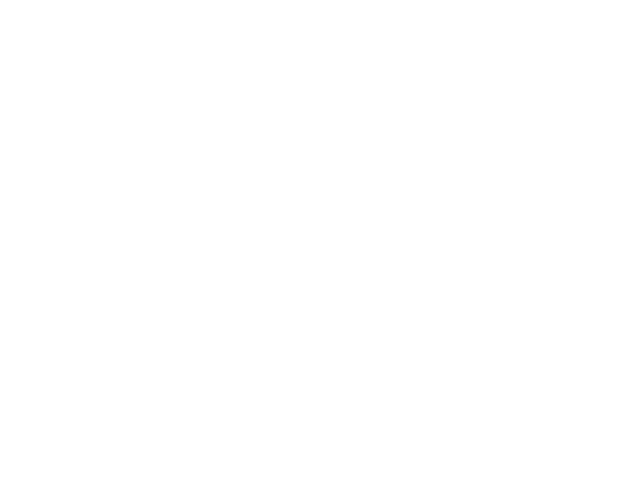

/fred/oz002/nthyagar/codes/others/python/PPTA_DR2E/parameterComparisonScripts/derive_PSRparms.py:229: RuntimeWarning: invalid value encountered in sqrt
  mp = NP.sqrt(mtot2[is_valid(mtot2)*is_valid(m2)]) - m2[is_valid(mtot2)*is_valid(m2)]

/fred/oz002/nthyagar/codes/others/python/PPTA_DR2E/parameterComparisonScripts/derive_PSRparms.py:183: RuntimeWarning: invalid value encountered in arcsin
  inc = NP.arcsin(sini)*180/NP.pi



In [22]:
psr_derived_parms = compare_parms['derived_params']
pta_psr_derived_parm_vals = {parm: {} for parm in psr_derived_parms}
for parm in psr_derived_parms:
    if 'Dpsr' in parm:
        outvals = NP.empty((len(psrnames_simple_union),len(ptas),3), dtype=NP.float128)
        outvals.fill(NP.nan)
    elif parm == 'psr_mass_parms':
        outvals = NP.empty((len(psrnames_simple_union),len(ptas),4,3), dtype=NP.float128)
        outvals.fill(NP.nan)        
    for ptai,pta in enumerate(ptas):
        for psri,psr in enumerate(psrnames_simple_union):
            if psr in pta_info[pta]['PSRnames_simple']:
                if pta == 'EPTA-DR1':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}/{0}.par'.format(psr)
                elif pta == 'NG-11yr':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}_NANOGrav_11yv1.gls.par'.format(psr)
                elif pta == 'NG-12.5yr-NB':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}_NANOGrav_12yv3.gls.par'.format(psr)
                elif pta == 'NG-12.5yr-WB':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}_NANOGrav_12yv3.wb.gls.par'.format(psr)
                elif pta == 'PPTA-DR1':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.par'.format(psr)
                elif (pta == 'PPTA-DR2O') or (pta == 'PPTA-DR2E'):
#                     parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.par'.format(psr)
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}_ecliptic.par'.format(psr)
                    if not path.exists(parfilename):
#                         parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.kop.par'.format(psr)
                        parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.kop_ecliptic.par'.format(psr)
                    if not path.exists(parfilename):
#                         parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.kop_alt.par'.format(psr)                    
                        parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.kop_alt_ecliptic.par'.format(psr)                    
                elif pta == 'PPTA-DR2':
                    parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.par'.format(psr)                    
                else:
                    raise ValueError('This PTA is either not requested in processing or unavailable in the database.')
                parmdict = readParFile.read_par(parfilename)
                if 'Dpsr' in parm:
                    if parm == 'Dpsr_PX':
                        outdict = derive_PSRparms.distance_from_parallax(parmdict, n_samples=100000)
                    elif parm == 'Dpsr_Pbdot':
                        outdict = derive_PSRparms.distance_from_pbdot(parmdict, n_samples=100000)
                    if isinstance(outdict, dict):
                        outvals[psri,ptai,:] = NP.asarray([outdict['dpsr'], outdict['dpsr_lolim'], outdict['dpsr_uplim']], dtype=NP.float128)
                elif parm == 'psr_mass_parms':
                    if (psr in compare_parms['psr_mass_parms']['spcl_psrs']) and (pta == 'PPTA-DR2'):
                        outdict = derive_combined_mass(parmdict, plot=False, n_samples=100000) 
                    else:
                        outdict = derive_PSRparms.mass_from_psrparms(parmdict, n_samples=100000)
                    if isinstance(outdict, dict):
                        outvals[psri,ptai,0,:] = NP.asarray([outdict['Mpsr'], outdict['Mpsr_lolim'], outdict['Mpsr_uplim']], dtype=NP.float128)
                        outvals[psri,ptai,1,:] = NP.asarray([outdict['M2'], outdict['M2_lolim'], outdict['M2_uplim']], dtype=NP.float128)
                        outvals[psri,ptai,2,:] = NP.asarray([outdict['Mtot'], outdict['Mtot_lolim'], outdict['Mtot_uplim']], dtype=NP.float128)
                        outvals[psri,ptai,3,:] = NP.asarray([outdict['inc'], outdict['inc_lolim'], outdict['inc_uplim']], dtype=NP.float128)
                        
    if 'Dpsr' in parm:
        pta_psr_derived_parm_vals[parm] = NP.copy(outvals)
    elif parm == 'psr_mass_parms':
        pta_psr_derived_parm_vals[parm] = {'Mpsr': NP.copy(outvals[:,:,0,:]), 'M2': NP.copy(outvals[:,:,1,:]), 'Mtot': NP.copy(outvals[:,:,2,:]), 'incl': NP.copy(outvals[:,:,3,:])}


In [23]:
psrind = psrnames_simple_union.index('J1600-3053')
print(psrind)
print(ptas)
print(pta_psr_derived_parm_vals.keys())
print(pta_psr_derived_parm_vals['Dpsr_PX'].shape)
print(NP.nanmax(pta_psr_derived_parm_vals['Dpsr_Pbdot']))
# print(pta_psr_derived_parm_vals['Dpsr_Pbdot']['EPTA_DR1'])
print(pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][psrind,0,:])
print(pta_psr_derived_parm_vals['psr_mass_parms']['M2'][psrind,0,:])
print(pta_psr_derived_parm_vals['psr_mass_parms']['Mtot'][psrind,0,:]**2)
print(pta_psr_derived_parm_vals['psr_mass_parms']['incl'][psrind,0,:])
ind_psr_in_ref_pta = NP.where(NP.isfinite(pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][:,ref_pta_ind,0]))[0]
print(NP.asarray(psrnames_simple_union)[ind_psr_in_ref_pta])
print(pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][ind_psr_in_ref_pta,ref_pta_ind,:])
print(ref_pta_ind)

27
['EPTA-DR1' 'NG-11yr' 'NG-12.5yr-NB' 'NG-12.5yr-WB' 'PPTA-DR1' 'PPTA-DR2O'
 'PPTA-DR2E' 'PPTA-DR2']
dict_keys(['Dpsr_PX', 'Dpsr_Pbdot', 'psr_mass_parms'])
(79, 8, 3)
1.1313432063738832e+16
[2.24607847 1.2906597  4.19992034]
[0.32676207 0.21645442 0.53433976]
[ 6.62454749  2.27178314 22.41172319]
[61.28215002 53.52329746 68.20479934]
['J0613-0200' 'J1017-7156' 'J1022+1001' 'J1125-6014' 'J1545-4550'
 'J1600-3053' 'J1713+0747' 'J1732-5049' 'J1857+0943' 'J1909-3744']
[[ 0.9019418   0.2973527   2.63655033]
 [ 1.99093964  1.25690818  2.72647207]
 [ 1.4374014   1.00846185  1.87670742]
 [ 1.52257525  1.28962173  1.7674021 ]
 [ 0.26703031 -0.13973841  1.78735375]
 [ 2.39349859  1.96320456  2.84305538]
 [ 1.27966274  1.20431942  1.35813331]
 [ 0.64544345  0.01986155  6.29663021]
 [ 1.53684851  1.41175146  1.66422043]
 [ 1.48721957  1.47695841  1.49756041]]
7


## Make comparison dictionaries for requested parameters by creating an Astropy table for each and save the derived parameters in an NPZ file

In [24]:
psrtables = {}
psrtables_fracdiff = {}
derived_psrtables = {}
for parm in psr_parms:
#     tabdict = {pta: pta_psr_parm_vals[parm][pta] for pta in ptas}
    tabdict = {pta: pta_psr_parm_uvals[parm][pta] for pta in ptas}
    psrtables[parm] = Table(copy.deepcopy(tabdict))
    psrtables[parm].add_column(Column(psrnames_simple_union, name='PSR'), index=0)

    tabdict_fracdiff = {pta: pta_psr_parm_uvals_fracdiff[parm][pta] for pta in ptas}
    psrtables_fracdiff[parm] = Table(copy.deepcopy(tabdict_fracdiff))
    psrtables_fracdiff[parm].add_column(Column(psrnames_simple_union, name='PSR'), index=0)
    
for parm in pta_psr_derived_parm_vals:
    if 'Dpsr' in parm:
        tabdict = {pta: pta_psr_derived_parm_vals[parm][:,ptai,:] for ptai, pta in enumerate(ptas)}
        derived_psrtables[parm] = Table(copy.deepcopy(tabdict))
        derived_psrtables[parm].add_column(Column(psrnames_simple_union, name='PSR'), index=0)
    elif parm == 'psr_mass_parms':
        for subparm in pta_psr_derived_parm_vals[parm]:
            tabdict = {pta: pta_psr_derived_parm_vals[parm][subparm][:,ptai,:] for ptai, pta in enumerate(ptas)}
            derived_psrtables[subparm] = Table(copy.deepcopy(tabdict))
            derived_psrtables[subparm].add_column(Column(psrnames_simple_union, name='PSR'), index=0)

NP.savez(outdir+'PSR_mass_parms.npz', Mpsr=pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'], M2=pta_psr_derived_parm_vals['psr_mass_parms']['M2'], Mtot=pta_psr_derived_parm_vals['psr_mass_parms']['Mtot'], incl=pta_psr_derived_parm_vals['psr_mass_parms']['incl'], psrnames=psrnames_simple_union, ptas=ptas)

In [25]:
print(psrtables.keys())

dict_keys(['PX', 'PMELAT', 'PMELONG'])


## Print PSR parameter tables

In [26]:
psrtables['PX'].show_in_notebook(display_length=100)

idx,PSR,EPTA-DR1,NG-11yr,NG-12.5yr-NB,NG-12.5yr-WB,PPTA-DR1,PPTA-DR2O,PPTA-DR2E,PPTA-DR2
0,J0023+0923,nan+/-nan,0.93+/-0.16,0.55+/-0.12,0.83+/-0.30,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
1,J0030+0451,2.91+/-0.25,3.08+/-0.08,3.09+/-0.06,3.14+/-0.07,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
2,J0034-0534,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
3,J0218+4232,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
4,J0340+4130,nan+/-nan,0.7+/-0.4,0.6+/-0.4,1.00+/-0.34,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
5,J0437-4715,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,6.37+/-0.09,nan+/-nan,nan+/-nan,nan+/-nan
6,J0610-2100,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
7,J0613-0200,1.31+/-0.16,0.93+/-0.20,0.90+/-0.11,0.91+/-0.12,0.86+/-0.12,1.00+/-0.09,1.01+/-0.09,1.01+/-0.09
8,J0621+1002,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
9,J0636+5128,nan+/-nan,0.88+/-0.30,1.38+/-0.23,1.35+/-0.23,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan


In [27]:
psrtables['PMELAT'].show_in_notebook(display_length=100)

idx,PSR,EPTA-DR1,NG-11yr,NG-12.5yr-NB,NG-12.5yr-WB,PPTA-DR1,PPTA-DR2O,PPTA-DR2E,PPTA-DR2
0,J0023+0923,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
1,J0030+0451,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
2,J0034-0534,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
3,J0218+4232,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
4,J0340+4130,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
5,J0437-4715,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
6,J0610-2100,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
7,J0613-0200,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,-10.300+/-0.014,-10.299+/-0.012,-10.299+/-0.012
8,J0621+1002,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
9,J0636+5128,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan


In [28]:
psrtables['PMELONG'].show_in_notebook(display_length=100)

idx,PSR,EPTA-DR1,NG-11yr,NG-12.5yr-NB,NG-12.5yr-WB,PPTA-DR1,PPTA-DR2O,PPTA-DR2E,PPTA-DR2
0,J0023+0923,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
1,J0030+0451,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
2,J0034-0534,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
3,J0218+4232,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
4,J0340+4130,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
5,J0437-4715,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
6,J0610-2100,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
7,J0613-0200,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,2.107+/-0.006,2.103+/-0.005,2.103+/-0.005
8,J0621+1002,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan
9,J0636+5128,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan,nan+/-nan


## Plot: Difference between various PTA estimates for each specified pulsar parameter along with uncertainties

<IPython.core.display.Javascript object>


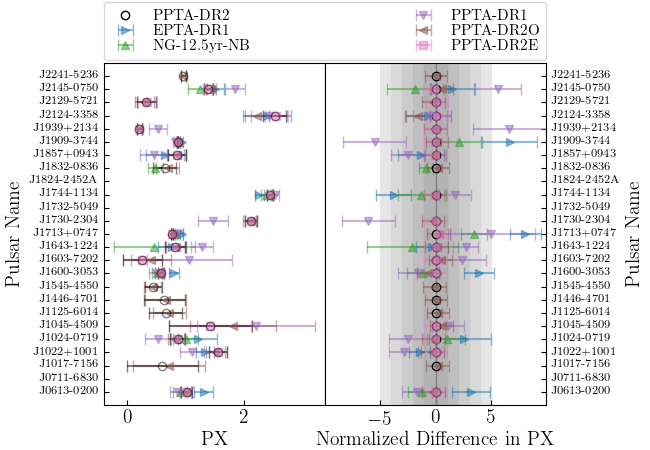

Saving figure at: /fred/oz002/nthyagar/projects/dr2_ephemerides/outputs/figures/PX_diff_info_portrait.pdf


<IPython.core.display.Javascript object>


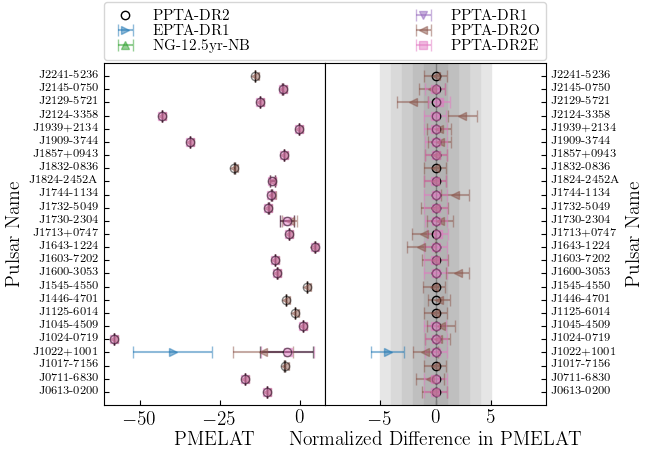

Saving figure at: /fred/oz002/nthyagar/projects/dr2_ephemerides/outputs/figures/PMELAT_diff_info_portrait.pdf


<IPython.core.display.Javascript object>


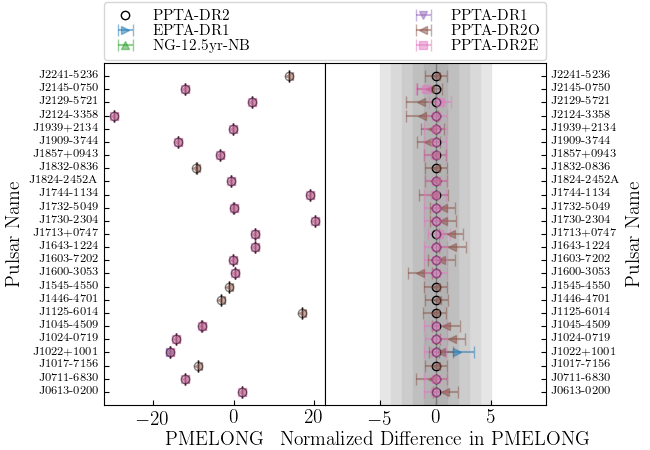

Saving figure at: /fred/oz002/nthyagar/projects/dr2_ephemerides/outputs/figures/PMELONG_diff_info_portrait.pdf


In [29]:
nsigma_fill = 5
nsigma_colors = NP.linspace(0.7, 0.9, nsigma_fill)

ptasymbols = ['>', 'd', '^', '*', 'v', '<', 's']
ptacolors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
for parm in psr_parms:
    ptas_to_plot = compare_parms[parm]['plot_PTAs']
    ind_ptas_to_plot = [ptas.tolist().index(pta_to_plot) for pta_to_plot in ptas_to_plot]

    parm_vals = unumpy.nominal_values(pta_psr_parm_uvals[parm]['all'])
    parm_err_vals = unumpy.std_devs(pta_psr_parm_uvals[parm]['all'])
    
    parm_diff_vals = unumpy.nominal_values(pta_psr_parm_uvals_diff[parm]['all'])
    parm_diff_err_vals = unumpy.std_devs(pta_psr_parm_uvals_diff[parm]['all'])
    
    fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharey=True, figsize=(6.5,4.5))

    for ptai in ind_ptas_to_plot:
        if ptas[ptai] != ref_pta:
            axs[0].errorbar(parm_vals[ref_pta_psrs_ind,ptai], NP.arange(len(ref_pta_psrs_ind)), xerr=parm_err_vals[ref_pta_psrs_ind,ptai], ls='none', marker=ptasymbols[ptai], color=ptacolors[ptai], ecolor=ptacolors[ptai], capsize=4, alpha=0.5, label='{0}'.format(ptas[ptai]))
    axs[0].errorbar(parm_vals[ref_pta_psrs_ind,ref_pta_ind], NP.arange(len(ref_pta_psrs_ind)), xerr=parm_err_vals[ref_pta_psrs_ind,ref_pta_ind], ls='none', marker='o', mfc='none', mec='black', mew=1, color='black', ecolor='black', capsize=4, alpha=0.5, label=ref_pta)

    axs[1].axvline(x=0, ls='-', lw=1, color='gray')
    for int_sigma in range(nsigma_fill,0,-1):
        axs[1].fill_betweenx(NP.asarray([-10,100]), -int_sigma, int_sigma, color='{0}'.format(nsigma_colors[int_sigma-1]))

    for ptai in ind_ptas_to_plot:
        if ptas[ptai] != ref_pta:
            axs[1].errorbar(parm_diff_vals[ref_pta_psrs_ind,ptai]/parm_err_vals[ref_pta_psrs_ind,ref_pta_ind], NP.arange(len(ref_pta_psrs_ind)), xerr=parm_err_vals[ref_pta_psrs_ind,ptai]/parm_err_vals[ref_pta_psrs_ind,ref_pta_ind], ls='none', marker=ptasymbols[ptai], color=ptacolors[ptai], ecolor=ptacolors[ptai], capsize=4, alpha=0.5, label='{0}'.format(ptas[ptai]))
    axs[1].plot(parm_diff_vals[ref_pta_psrs_ind,ref_pta_ind]/parm_err_vals[ref_pta_psrs_ind,ref_pta_ind], NP.arange(len(ref_pta_psrs_ind)), ls='none', marker='o', mfc='none', mec='black', mew=1, label=ref_pta)
#     axs[1].errorbar(parm_diff_vals[ref_pta_psrs_ind,ref_pta_ind]/parm_err_vals[ref_pta_psrs_ind,ref_pta_ind], NP.arange(len(ref_pta_psrs_ind)), xerr=parm_err_vals[ref_pta_psrs_ind,ref_pta_ind]/parm_err_vals[ref_pta_psrs_ind,ref_pta_ind], ls='none', marker='o', mfc='none', mec='black', mew=1, color='black', ecolor='black', capsize=4, alpha=0.5, label=ref_pta)
#     axs[0].legend(loc='upper center', ncol=2, shadow=False, fontsize=8.25, labelspacing=0, columnspacing=0)
#     axs[1].legend(loc='upper center', ncol=2, shadow=False, fontsize=8.25, labelspacing=0, columnspacing=0)
    axs[1].legend(bbox_to_anchor=(-1., 1.01, 2., .05), loc='lower left', ncol=2, mode='expand', borderaxespad=0., shadow=False, fontsize=11, labelspacing=0, columnspacing=0)
    axs[0].set_ylim(-1,len(ref_pta_psrs_ind))
    axs[1].set_ylim(-1,len(ref_pta_psrs_ind))
    axs[1].set_xlim(-9.95,9.95)
    axs[0].set_yticks(NP.arange(len(ref_pta_psrs_ind)))
    axs[0].set_yticklabels(ref_pta_psrs, fontdict={'fontsize': 8.5, 'ha': 'right', 'va': 'center', 'family': 'serif'})
    axs[0].tick_params(direction='in', labelleft=True)
    axs[0].set_ylabel('Pulsar Name')
    axs[0].set_xlabel('{0}'.format(parm))
    axs[1].set_xlabel('Normalized Difference in {0}'.format(parm))
    axs[1].set_yticks(NP.arange(len(ref_pta_psrs_ind)))
    axs[1].set_yticklabels(ref_pta_psrs, fontdict={'fontsize': 8.5, 'ha': 'left', 'va': 'center', 'family': 'serif'})
    axs[1].yaxis.tick_right()
    axs[1].tick_params(direction='in', labelright=True)
    axs[1].yaxis.set_label_position('right')
    axs[1].set_ylabel('Pulsar Name')
    fig.subplots_adjust(hspace=0, wspace=0)
    fig.subplots_adjust(left=0.16, right=0.84, bottom=0.1, top=0.86)
    
    PLT.savefig(figdir + '{0}_diff_info_portrait.pdf'.format(parm), bbox_inches=0)
    print('Saving figure at: ' + figdir + '{0}_diff_info_portrait.pdf'.format(parm))

## Plot derived PSR distances

<IPython.core.display.Javascript object>


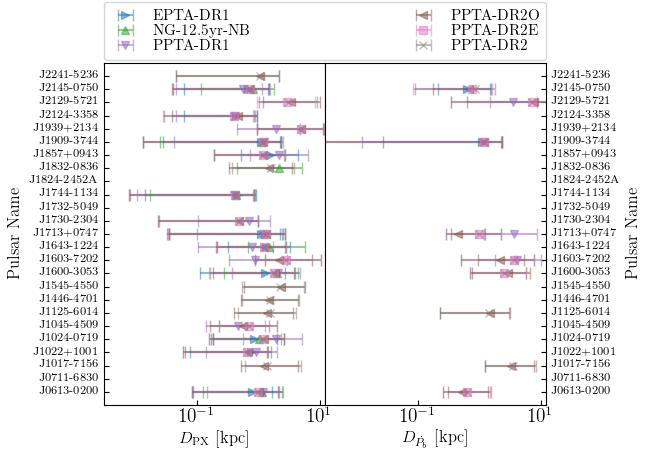

Saving figure at: /fred/oz002/nthyagar/projects/dr2_ephemerides/outputs/figures/Dpsr_portrait.pdf


In [30]:
ptas_to_plot = compare_parms['Dpsr']['plot_PTAs']
ind_ptas_to_plot = [ptas.tolist().index(pta_to_plot) for pta_to_plot in ptas_to_plot]

ptasymbols = ['>', 'd', '^', '*', 'v', '<', 's', 'x']
ptacolors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharey=True, figsize=(6.5,4.5))

for ptai in ind_ptas_to_plot:
    axs[0].errorbar(pta_psr_derived_parm_vals['Dpsr_PX'][ref_pta_psrs_ind,ptai,0], NP.arange(len(ref_pta_psrs_ind)), xerr=pta_psr_derived_parm_vals['Dpsr_PX'][ref_pta_psrs_ind,ptai,1:].T, ls='none', marker=ptasymbols[ptai], color=ptacolors[ptai], ecolor=ptacolors[ptai], capsize=4, alpha=0.5, label='{0}'.format(ptas[ptai]))
    axs[1].errorbar(pta_psr_derived_parm_vals['Dpsr_Pbdot'][ref_pta_psrs_ind,ptai,0], NP.arange(len(ref_pta_psrs_ind)), xerr=pta_psr_derived_parm_vals['Dpsr_Pbdot'][ref_pta_psrs_ind,ptai,1:].T, ls='none', marker=ptasymbols[ptai], color=ptacolors[ptai], ecolor=ptacolors[ptai], capsize=4, alpha=0.5, label='{0}'.format(ptas[ptai]))

axs[1].legend(bbox_to_anchor=(-1., 1.01, 2., .05), loc='lower left', ncol=2, mode='expand', borderaxespad=0., shadow=False, fontsize=11, labelspacing=0, columnspacing=0)
axs[0].set_ylim(-1,len(ref_pta_psrs_ind))
axs[1].set_ylim(-1,len(ref_pta_psrs_ind))
axs[0].set_xlim(0.003,12)
axs[1].set_xlim(0.003,12)
axs[0].set_xscale('log')
axs[1].set_xscale('log')
axs[0].set_yticks(NP.arange(len(ref_pta_psrs_ind)))
axs[0].set_yticklabels(ref_pta_psrs, fontdict={'fontsize': 8.5, 'ha': 'right', 'va': 'center', 'family': 'serif'})
axs[0].tick_params(direction='in', labelleft=True)
axs[0].set_ylabel('Pulsar Name', fontsize=12)
axs[0].set_xlabel(r'$D_{\mathrm{PX}}$ [kpc]', fontsize=12)
axs[1].set_xlabel(r'$D_{\dot{P_b}}$ [kpc]', fontsize=12)
axs[1].set_yticks(NP.arange(len(ref_pta_psrs_ind)))
axs[1].set_yticklabels(ref_pta_psrs, fontdict={'fontsize': 8.5, 'ha': 'left', 'va': 'center', 'family': 'serif'})
axs[1].yaxis.tick_right()
axs[1].tick_params(direction='in', labelright=True)
axs[1].yaxis.set_label_position('right')
axs[1].set_ylabel('Pulsar Name', fontsize=12)
fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.16, right=0.84, bottom=0.1, top=0.86)
   
PLT.savefig(figdir + 'Dpsr_portrait.pdf', bbox_inches=0)
print('Saving figure at: ' + figdir + 'Dpsr_portrait.pdf')           

## Plot derived masses of the binary system

<IPython.core.display.Javascript object>


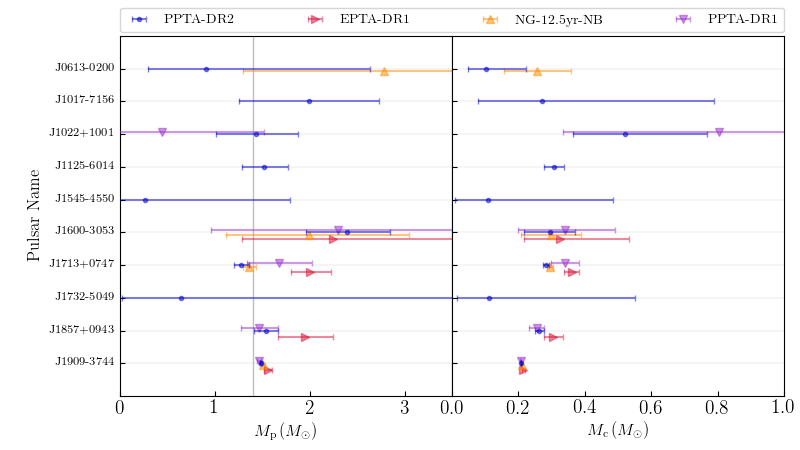

Saving figure at: /fred/oz002/nthyagar/projects/dr2_ephemerides/outputs/figures/mass_portrait_linplot_PPTA-DR2.pdf


In [35]:
ptas_to_plot = compare_parms['psr_mass_parms']['plot_PTAs']
excl_psrs = compare_parms['psr_mass_parms']['excl_psrs']
ind_ptas_to_plot = [ptas.tolist().index(pta_to_plot) for pta_to_plot in ptas_to_plot]
ind_psr_in_ref_pta = NP.where(NP.isfinite(pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][:,ref_pta_ind,0]))[0]
ind_psr_in_ref_pta = NP.asarray([ind for ind in ind_psr_in_ref_pta if psrnames_simple_union[ind] not in excl_psrs])

if len(ind_ptas_to_plot)%2 == 1:
    pta_yoffset = NP.linspace(-0.2, 0.2, len(ind_ptas_to_plot)-1, endpoint=True)
else:
    pta_yoffset = NP.linspace(-0.2, 0.2, len(ind_ptas_to_plot), endpoint=True)[:-1]

pta_yoffset = NP.insert(pta_yoffset, ind_ptas_to_plot.index(ref_pta_ind), 0.0)

ptasymbols = ['>', 'd', '^', '*', 'v', '<', 's', '+']
ptacolors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7']
ptasymbols[ptas.tolist().index('EPTA-DR1')] = '>'
ptacolors[ptas.tolist().index('EPTA-DR1')] = 'crimson'
ptasymbols[ptas.tolist().index('NG-12.5yr-NB')] = '^'
ptacolors[ptas.tolist().index('NG-12.5yr-NB')] = 'darkorange'
ptasymbols[ptas.tolist().index('PPTA-DR1')] = 'v'
ptacolors[ptas.tolist().index('PPTA-DR1')] = 'darkorchid'
ptasymbols[ref_pta_ind] = '.'
ptacolors[ref_pta_ind] = 'mediumblue'

fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharey=True, figsize=(8,4.5))

axs[0].axvline(x=1.4, ls='-', lw=1, color='0.75')
axs[0].errorbar(pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][ind_psr_in_ref_pta,ref_pta_ind,0], NP.arange(len(ind_psr_in_ref_pta))[::-1]+pta_yoffset[ind_ptas_to_plot.index(ref_pta_ind)], xerr=NP.abs(pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][ind_psr_in_ref_pta,ref_pta_ind,1:].T - pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][ind_psr_in_ref_pta,ref_pta_ind,0].reshape(1,-1)), ls='none', marker=ptasymbols[ref_pta_ind], ms=6, mec=ptacolors[ref_pta_ind], mfc=ptacolors[ref_pta_ind], color=ptacolors[ref_pta_ind], ecolor=ptacolors[ref_pta_ind], capsize=2, alpha=0.5, label='{0}'.format(str(ptas[ref_pta_ind])), zorder=10)
axs[1].errorbar(pta_psr_derived_parm_vals['psr_mass_parms']['M2'][ind_psr_in_ref_pta,ref_pta_ind,0], NP.arange(len(ind_psr_in_ref_pta))[::-1]+pta_yoffset[ind_ptas_to_plot.index(ref_pta_ind)], xerr=NP.abs(pta_psr_derived_parm_vals['psr_mass_parms']['M2'][ind_psr_in_ref_pta,ref_pta_ind,1:].T - pta_psr_derived_parm_vals['psr_mass_parms']['M2'][ind_psr_in_ref_pta,ref_pta_ind,0].reshape(1,-1)), ls='none', marker=ptasymbols[ref_pta_ind], ms=6, mec=ptacolors[ref_pta_ind], mfc=ptacolors[ref_pta_ind], color=ptacolors[ref_pta_ind], ecolor=ptacolors[ref_pta_ind], capsize=2, alpha=0.5, label='{0}'.format(str(ptas[ref_pta_ind])), zorder=10)        
for ptaiind, ptai in enumerate(ind_ptas_to_plot):
    if ptai != ref_pta_ind:
        axs[0].errorbar(pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][ind_psr_in_ref_pta,ptai,0], NP.arange(len(ind_psr_in_ref_pta))[::-1]+pta_yoffset[ptaiind], xerr=NP.abs(pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][ind_psr_in_ref_pta,ptai,1:].T - pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][ind_psr_in_ref_pta,ptai,0].reshape(1,-1)), ls='none', marker=ptasymbols[ptai], mec=ptacolors[ptai], mfc=ptacolors[ptai], color=ptacolors[ptai], ecolor=ptacolors[ptai], capsize=2, alpha=0.5, label='{0}'.format(str(ptas[ptai])), zorder=5)
        axs[1].errorbar(pta_psr_derived_parm_vals['psr_mass_parms']['M2'][ind_psr_in_ref_pta,ptai,0], NP.arange(len(ind_psr_in_ref_pta))[::-1]+pta_yoffset[ptaiind], xerr=NP.abs(pta_psr_derived_parm_vals['psr_mass_parms']['M2'][ind_psr_in_ref_pta,ptai,1:].T - pta_psr_derived_parm_vals['psr_mass_parms']['M2'][ind_psr_in_ref_pta,ptai,0].reshape(1,-1)), ls='none', marker=ptasymbols[ptai], mec=ptacolors[ptai], mfc=ptacolors[ptai], color=ptacolors[ptai], ecolor=ptacolors[ptai], capsize=2, alpha=0.5, label='{0}'.format(str(ptas[ptai])), zorder=5)
# axs[0].errorbar(pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][ind_psr_in_ref_pta,ref_pta_ind,0], NP.arange(len(ind_psr_in_ref_pta))+pta_yoffset[ind_ptas_to_plot.index(ref_pta_ind)], xerr=NP.abs(pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][ind_psr_in_ref_pta,ref_pta_ind,1:].T - pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][ind_psr_in_ref_pta,ref_pta_ind,0].reshape(1,-1)), ls='none', marker=ptasymbols[ref_pta_ind], color=ptacolors[ref_pta_ind], ecolor=ptacolors[ref_pta_ind], capsize=4, alpha=0.5)
# axs[1].errorbar(pta_psr_derived_parm_vals['psr_mass_parms']['M2'][ind_psr_in_ref_pta,ref_pta_ind,0], NP.arange(len(ind_psr_in_ref_pta))+pta_yoffset[ind_ptas_to_plot.index(ref_pta_ind)], xerr=NP.abs(pta_psr_derived_parm_vals['psr_mass_parms']['M2'][ind_psr_in_ref_pta,ref_pta_ind,1:].T - pta_psr_derived_parm_vals['psr_mass_parms']['M2'][ind_psr_in_ref_pta,ref_pta_ind,0].reshape(1,-1)), ls='none', marker=ptasymbols[ref_pta_ind], color=ptacolors[ref_pta_ind], ecolor=ptacolors[ref_pta_ind], capsize=4, alpha=0.5)        

axs[0].grid(axis='y', lw=0.2, color='0.75')
axs[1].grid(axis='y', lw=0.2, color='0.75')
axs[1].legend(bbox_to_anchor=(-1., 1.01, 2., .05), loc='lower left', ncol=len(ptas_to_plot), mode='expand', borderaxespad=0., shadow=False, fontsize=10, labelspacing=0, columnspacing=0)
axs[0].set_ylim(-1,len(ind_psr_in_ref_pta))
axs[1].set_ylim(-1,len(ind_psr_in_ref_pta))
# axs[0].set_xlim(0.005,30) # for log plot
# axs[1].set_xlim(0.0005,11) # for log plot
# axs[0].set_xscale('log', subsx=[2, 3, 4, 5, 6, 7, 8, 9])
# axs[1].set_xscale('log', subsx=[2, 3, 4, 5, 6, 7, 8, 9])
axs[0].set_xlim(0,3.5) # for linear plot
axs[1].set_xlim(0,1) # for linear plot
axs[0].set_yticks(NP.arange(len(ind_psr_in_ref_pta)))
axs[0].set_yticklabels(NP.asarray(psrnames_simple_union)[ind_psr_in_ref_pta][::-1], fontdict={'fontsize': 8.5, 'ha': 'right', 'va': 'center', 'family': 'serif'})
# axs[0].set_yticks(NP.arange(len(ref_pta_psrs_ind)))
# axs[0].set_yticklabels(ref_pta_psrs, fontdict={'fontsize': 8.5, 'ha': 'right', 'va': 'center', 'family': 'serif'})
axs[0].tick_params(which='both', direction='in', labelleft=True)
axs[0].set_ylabel('Pulsar Name', fontsize=12)
axs[0].set_xlabel(r'$M_{\mathrm{p}}\, (M_\odot)$', fontsize=12)
# ticklocsmajor = LogLocator(base=10,numticks=4) 
# ticklocsminor = LogLocator(base=10.0,subs=(0.2,0.4,0.6,0.8),numticks=4)
# axs[0].xaxis.set_major_locator(ticklocsmajor)
# axs[0].xaxis.set_minor_locator(ticklocsminor)
# axs[0].xaxis.set_minor_formatter(NullFormatter())
# axs[0].xaxis.set_minor_formatter(FormatStrFormatter("%.2f"))
axs[1].set_xlabel(r'$M_{\mathrm{c}}\, (M_\odot)$', fontsize=12)
axs[1].set_yticks(NP.arange(len(ind_psr_in_ref_pta)))
# axs[1].set_yticklabels(NP.asarray(psrnames_simple_union)[ind_psr_in_ref_pta], fontdict={'fontsize': 8.5, 'ha': 'left', 'va': 'center', 'family': 'serif'})
# axs[1].yaxis.tick_right()
axs[1].tick_params(which='both', direction='in')
# axs[1].yaxis.set_label_position('right')
# axs[1].set_ylabel('Pulsar Name', fontsize=12)
fig.subplots_adjust(hspace=0, wspace=0)
fig.subplots_adjust(left=0.15, right=0.98, bottom=0.12, top=0.92)
   
PLT.savefig(figdir + 'mass_portrait_linplot_{0}.pdf'.format(ref_pta), bbox_inches=0)
print('Saving figure at: ' + figdir + 'mass_portrait_linplot_{0}.pdf'.format(ref_pta))           

In [67]:
print(ptas)
print(NP.asarray(psrnames_simple_union)[ind_psr_in_ref_pta])
print(pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][ind_psr_in_ref_pta,ref_pta_ind,:])
print(pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][ind_psr_in_ref_pta,0,:])
print(pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][ind_psr_in_ref_pta,2,:])

['EPTA-DR1' 'NG-11yr' 'NG-12.5yr-NB' 'NG-12.5yr-WB' 'PPTA-DR1' 'PPTA-DR2O'
 'PPTA-DR2E' 'PPTA-DR2']
['J0613-0200' 'J1017-7156' 'J1022+1001' 'J1125-6014' 'J1545-4550'
 'J1600-3053' 'J1713+0747' 'J1732-5049' 'J1857+0943' 'J1909-3744']
[[ 0.90473086  0.30209152  2.65932192]
 [ 1.97120619  1.22703236  2.71835728]
 [ 1.43972808  1.01154062  1.87184013]
 [ 1.5220131   1.28950206  1.76882631]
 [ 0.2608396  -0.14819956  1.78066244]
 [ 2.39022972  1.96576699  2.83716539]
 [ 1.27896499  1.20208299  1.35753872]
 [ 0.62917993  0.01851905  6.22403665]
 [ 1.53687288  1.4127361   1.66484019]
 [ 1.48729201  1.47698289  1.49758736]]
[[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]]
[[2.78028215 1.26161991 4.64679233]
 [       nan        nan        nan]
 [       nan        nan        nan]
 [       nan        nan        nan]
 [       nan        nan        nan]
 [1.99496636 1.11663786 3.04296683]
 [1.36400

In [ ]:
ind_psr_in_all_pta = []
for ptaiind, ptai in enumerate(ind_ptas_to_plot):
    ind_tmp = NP.where(NP.isfinite(pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][:,ptai,0]))[0]
    ind_psr_in_all_pta = NP.union1d(ind_psr_in_all_pta, ind_tmp)
ind_psr_in_rest_pta = NP.setdiff1d(ind_psr_in_all_pta, ind_psr_in_ref_pta).astype(NP.int)
# print(ind_psr_in_ref_pta)
# print(ind_psr_in_rest_pta)
ind3d = NP.ix_(ind_psr_in_rest_pta,ind_ptas_to_plot,[0])
print(ptas_to_plot)
print(pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][ind3d].squeeze())
print(NP.asarray(psrnames_simple_union)[ind_psr_in_rest_pta.tolist()])
# print(zip(NP.asarray(psrnames_simple_union)[ind_psr_in_rest_pta.tolist()], pta_psr_derived_parm_vals['psr_mass_parms']['Mpsr'][ind3d].squeeze()))

## Plot: Fractional difference between various PTA estimates for each specified pulsar parameter along with uncertainties

In [ ]:
# ptas_to_plot = compare_parms['plot_PTAs']
# ind_ptas_to_plot = [ptas.tolist().index(pta_to_plot) for pta_to_plot in ptas_to_plot]

# ptasymbols = ['>', 'd', '^', '*', 'v', '<', 's']
# ptacolors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
# for parm in psr_parms:
#     parm_vals = unumpy.nominal_values(pta_psr_parm_uvals[parm]['all'])
#     parm_err_vals = unumpy.std_devs(pta_psr_parm_uvals[parm]['all'])
    
#     parm_fracdiff_vals = unumpy.nominal_values(pta_psr_parm_uvals_fracdiff[parm]['all'])
#     parm_fracdiff_err_vals = unumpy.std_devs(pta_psr_parm_uvals_fracdiff[parm]['all'])
    
#     fig, axs = PLT.subplots(nrows=2, ncols=1, sharex=True, figsize=(4.5,5))

#     axs[0].errorbar(NP.arange(len(ref_pta_psrs_ind)), parm_vals[ref_pta_psrs_ind,ref_pta_ind], yerr=parm_err_vals[ref_pta_psrs_ind,ref_pta_ind], ls='none', marker='o', mfc='none', mec='black', mew=1, color='black', ecolor='black', capsize=4, alpha=0.5, label=ref_pta+' [Ref]')
#     for ptai in ind_ptas_to_plot:
#         if ptas[ptai] != ref_pta:
#             axs[0].errorbar(NP.arange(len(ref_pta_psrs_ind)), parm_vals[ref_pta_psrs_ind,ptai], yerr=parm_err_vals[ref_pta_psrs_ind,ptai], ls='none', marker=ptasymbols[ptai], color=ptacolors[ptai], ecolor=ptacolors[ptai], capsize=4, alpha=0.5, label='{0}'.format(ptas[ptai]))

# #     axs[1].fill_between(NP.asarray([-10,100]), -1, 1, color='lightgray')
#     for ptai in ind_ptas_to_plot:
#         if ptas[ptai] != ref_pta:
#             axs[1].errorbar(NP.arange(len(ref_pta_psrs_ind)), parm_fracdiff_vals[ref_pta_psrs_ind,ptai], yerr=parm_fracdiff_err_vals[ref_pta_psrs_ind,ptai], ls='none', marker=ptasymbols[ptai], color=ptacolors[ptai], ecolor=ptacolors[ptai], capsize=4, alpha=0.5, label='{0}'.format(ptas[ptai]))
#     axs[1].plot(NP.arange(len(ref_pta_psrs_ind)), parm_fracdiff_vals[ref_pta_psrs_ind,ref_pta_ind], ls='none', marker='o', mfc='none', mec='black', mew=1, label=ref_pta+' [Ref]')
#     axs[0].legend(loc='upper center', ncol=2, shadow=False, fontsize=9, labelspacing=0, columnspacing=0)
#     axs[1].legend(loc='lower left', ncol=2, shadow=False, fontsize=9, labelspacing=0, columnspacing=0)
#     axs[1].set_xlim(-1,len(ref_pta_psrs_ind)+1)
#     axs[1].set_ylim(-1,1)
#     axs[1].set_xticks(NP.arange(len(ref_pta_psrs_ind)))
#     axs[1].set_xticklabels(ref_pta_psrs, rotation='vertical', fontdict={'fontsize': 8, 'ha': 'center', 'va': 'top', 'family': 'serif'})
#     axs[1].set_xlabel('Pulsar')
#     axs[0].set_ylabel('{0}'.format(parm))
#     axs[1].set_ylabel('Fractional Difference in {0}'.format(parm))
#     fig.subplots_adjust(hspace=0, wspace=0)
#     fig.subplots_adjust(left=0.05, right=0.99, bottom=0.15, top=0.98)
    
# #     PLT.savefig(figdir + '{0}_info_landscape.pdf'.format(parm), bbox_inches=0)
#     print('Saving figure at: ' + figdir + '{0}_info_landscape.pdf'.format(parm))

## Same plot as above but in portrait mode

In [ ]:
# ptas_to_plot = compare_parms['plot_PTAs']
# ind_ptas_to_plot = [ptas.tolist().index(pta_to_plot) for pta_to_plot in ptas_to_plot]

# ptasymbols = ['>', 'd', '^', '*', 'v', '<', 's']
# ptacolors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
# for parm in psr_parms:
#     parm_vals = unumpy.nominal_values(pta_psr_parm_uvals[parm]['all'])
#     parm_err_vals = unumpy.std_devs(pta_psr_parm_uvals[parm]['all'])
    
#     parm_fracdiff_vals = unumpy.nominal_values(pta_psr_parm_uvals_fracdiff[parm]['all'])
#     parm_fracdiff_err_vals = unumpy.std_devs(pta_psr_parm_uvals_fracdiff[parm]['all'])
    
#     fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharey=True, figsize=(5,4.5))

#     for ptai in ind_ptas_to_plot:
#         if ptas[ptai] != ref_pta:
#             axs[0].errorbar(parm_vals[ref_pta_psrs_ind,ptai], NP.arange(len(ref_pta_psrs_ind)), xerr=parm_err_vals[ref_pta_psrs_ind,ptai], ls='none', marker=ptasymbols[ptai], color=ptacolors[ptai], ecolor=ptacolors[ptai], capsize=4, alpha=0.5, label='{0}'.format(ptas[ptai]))
#     axs[0].errorbar(parm_vals[ref_pta_psrs_ind,ref_pta_ind], NP.arange(len(ref_pta_psrs_ind)), xerr=parm_err_vals[ref_pta_psrs_ind,ref_pta_ind], ls='none', marker='o', mfc='none', mec='black', mew=1, color='black', ecolor='black', capsize=4, alpha=0.5, label=ref_pta)

# #     axs[1].fill_betweenx(NP.asarray([-10,100]), -1, 1, color='lightgray')
#     for ptai in ind_ptas_to_plot:
#         if ptas[ptai] != ref_pta:
#             axs[1].errorbar(parm_fracdiff_vals[ref_pta_psrs_ind,ptai], NP.arange(len(ref_pta_psrs_ind)), xerr=parm_fracdiff_err_vals[ref_pta_psrs_ind,ptai], ls='none', marker=ptasymbols[ptai], color=ptacolors[ptai], ecolor=ptacolors[ptai], capsize=4, alpha=0.5, label='{0}'.format(ptas[ptai]))
#     axs[1].plot(parm_fracdiff_vals[ref_pta_psrs_ind,ref_pta_ind], NP.arange(len(ref_pta_psrs_ind)), ls='none', marker='o', mfc='none', mec='black', mew=1, label=ref_pta+' [Ref]')
# #     axs[0].legend(loc='center right', ncol=1, shadow=False, fontsize=7.5, labelspacing=0)
#     axs[1].legend(loc='upper left', ncol=2, shadow=False, fontsize=8.25, labelspacing=0.2, columnspacing=0.1)
#     axs[0].set_ylim(-1,len(ref_pta_psrs_ind)+4)
#     axs[1].set_ylim(-1,len(ref_pta_psrs_ind)+4)
#     axs[1].set_xlim(-1,1)
#     axs[0].set_yticks(NP.arange(len(ref_pta_psrs_ind)))
#     axs[0].set_yticklabels(ref_pta_psrs, fontdict={'fontsize': 8, 'ha': 'right', 'va': 'center', 'family': 'serif'})
#     axs[0].tick_params(direction='in', labelleft=True)
#     axs[0].set_ylabel('Pulsar')
#     axs[0].set_xlabel('{0}'.format(parm))
#     axs[1].set_xlabel('Fractional Difference in {0}'.format(parm))
#     axs[1].set_yticks(NP.arange(len(ref_pta_psrs_ind)))
#     axs[1].set_yticklabels(ref_pta_psrs, fontdict={'fontsize': 8, 'ha': 'left', 'va': 'center', 'family': 'serif'})
#     axs[1].yaxis.tick_right()
#     axs[1].tick_params(direction='in', labelright=True)
#     axs[1].yaxis.set_label_position('right')
#     axs[1].set_ylabel('Pulsar')
#     fig.subplots_adjust(hspace=0, wspace=0)
#     fig.subplots_adjust(left=0.15, right=0.85, bottom=0.05, top=0.98)
    
# #     PLT.savefig(figdir + '{0}_info_portrait.pdf'.format(parm), bbox_inches=0)
#     print('Saving figure at: ' + figdir + '{0}_info_portrait.pdf'.format(parm))

In [ ]:
# compare_parms = parms['compareParms']
# psr_parms = compare_parms['params']
# ptas = NP.asarray(compare_parms['PTA'])
# pta_psr_parm_vals = {parm: {} for parm in psr_parms}
# pta_psr_parm_vals_normratio = {parm: {} for parm in psr_parms}
# ref_pta = compare_parms['ref_PTA']
# ref_pta_ind = ptas.tolist().index(ref_pta)
# rest_pta_ind = NP.setdiff1d(NP.arange(ptas.size), ref_pta_ind)
# rest_ptas = ptas[rest_pta_ind]

# for parm in psr_parms:
#     outvals = NP.empty((len(psrnames_simple_union),len(ptas),2), dtype=NP.float128)
#     outvals.fill(NP.nan)
#     for ptai,pta in enumerate(ptas):
#         for psri,psr in enumerate(psrnames_simple_union):
#             if psr in pta_info[pta]['PSRnames_simple']:
#                 if pta == 'EPTA_DR1':
#                     parfilename = pta_dir_info[pta]['PSRdir'] + '{0}/{0}.par'.format(psr)
#                 elif pta == 'NG_11yr':
#                     parfilename = pta_dir_info[pta]['PSRdir'] + '{0}_NANOGrav_11yv1.gls.par'.format(psr)
#                 elif pta == 'NG_12.5yr_NB':
#                     parfilename = pta_dir_info[pta]['PSRdir'] + '{0}_NANOGrav_12yv3.gls.par'.format(psr)
#                 elif pta == 'NG_12.5yr_WB':
#                     parfilename = pta_dir_info[pta]['PSRdir'] + '{0}_NANOGrav_12yv3.wb.gls.par'.format(psr)
#                 elif pta == 'PPTA_DR1':
#                     parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.par'.format(psr)
#                 elif (pta == 'PPTA_DR2') or (pta == 'PPTA_DR2E'):
#                     parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.par'.format(psr)
#                     if not path.exists(parfilename):
#                         parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.kop.par'.format(psr)
#                     if not path.exists(parfilename):
#                         parfilename = pta_dir_info[pta]['PSRdir'] + '{0}.kop_alt.par'.format(psr)                    
#                 else:
#                     raise ValueError('This PTA is either not requested in processing or unavailable in the database.')
#                 parmdict = readParFile.read_par(parfilename)
#                 if (parm in parmdict) and (parm+'_ERR' in parmdict):
#                     pval = parmdict[parm]
#                     pvalerr = parmdict[parm+'_ERR']
#                     outvals[psri,ptai,:] = NP.asarray([pval, pvalerr], dtype=NP.float128)
#         pta_psr_parm_vals[parm][pta] = MA.array(outvals[:,ptai,:], mask=NP.isnan(outvals[:,ptai,:]))
#     pta_psr_parm_vals[parm]['all'] = MA.array(outvals, mask=NP.isnan(outvals))
#     vals_normratio = NP.zeros((len(psrnames_simple_union),len(ptas),2), dtype=NP.float128)
#     vals_normratio[:,:,0] = (outvals[:,:,0] - outvals[:,[ref_pta_ind],0]) / outvals[:,[ref_pta_ind],0]
#     vals_normratio[:,:,1] = outvals[:,:,1] / outvals[:,[ref_pta_ind],1]
#     pta_psr_parm_vals_normratio[parm]['all'] = MA.array(vals_normratio, mask=NP.isnan(vals_normratio))
    
#     for psri,psr in enumerate(psrnames_simple_union):
#         pta_psr_parm_vals[parm][psr] = MA.array(outvals[psri,:,:], mask=NP.isnan(outvals[psri,:,:]))
#         pta_psr_parm_vals_normratio[parm][psr] = MA.array(vals_normratio[psri,:,:], mask=NP.isnan(vals_normratio[psri,:,:]))

## Plot: Fractional difference between various PTA estimates for each specified pulsar parameter

In [ ]:
# ptas_to_plot = compare_parms['plot_PTAs']
# ind_ptas_to_plot = [ptas.tolist().index(pta_to_plot) for pta_to_plot in ptas_to_plot]
# ptasymbols = ['>', 'd', '^', '*', 'v', '<', 's']
# ptacolors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
# for parm in psr_parms:
#     fig, axs = PLT.subplots(nrows=2, ncols=1, sharex=True, figsize=(12,8))

#     axs[0].errorbar(NP.arange(len(psrnames_simple_union)), pta_psr_parm_vals[parm]['all'][:,ref_pta_ind,0], yerr=pta_psr_parm_vals[parm]['all'][:,ref_pta_ind,1], ls='none', marker='o', mfc='none', mec='black', mew=1, color='black', ecolor='black', capsize=4, alpha=0.5, label=ref_pta+' [Ref]')
#     for ptai in ind_ptas_to_plot:
#         if ptas[ptai] != ref_pta:
#             axs[0].errorbar(NP.arange(len(psrnames_simple_union)), pta_psr_parm_vals[parm]['all'][:,ptai,0], yerr=pta_psr_parm_vals[parm]['all'][:,ptai,1], ls='none', marker=ptasymbols[ptai], color=ptacolors[ptai], ecolor=ptacolors[ptai], capsize=4, alpha=0.5, label='{0}'.format(ptas[ptai]))

#     axs[1].fill_between(NP.asarray([-10,100]), -1, 1, color='lightgray')
#     for ptai in ind_ptas_to_plot:
#         if ptas[ptai] != ref_pta:
#             axs[1].errorbar(NP.arange(len(psrnames_simple_union)), pta_psr_parm_vals_normratio[parm]['all'][:,ptai,0], yerr=pta_psr_parm_vals_normratio[parm]['all'][:,ptai,1], ls='none', marker=ptasymbols[ptai], color=ptacolors[ptai], ecolor=ptacolors[ptai], capsize=4, alpha=0.5, label='{0}'.format(ptas[ptai]))
#     axs[1].plot(NP.arange(len(psrnames_simple_union)), pta_psr_parm_vals_normratio[parm]['all'][:,ref_pta_ind,0], ls='none', marker='o', mfc='none', mec='black', mew=1, label=ref_pta+' [Ref]')
#     axs[0].legend(loc='lower right', ncol=2, shadow=False, fontsize=11, labelspacing=0.2)
#     axs[1].legend(loc='lower left', ncol=2, shadow=False, fontsize=11, labelspacing=0.2)
#     axs[1].set_xlim(-1,len(psrnames_simple_union)+1)
#     axs[1].set_xticks(NP.arange(len(psrnames_simple_union)))
#     axs[1].set_xticklabels(psrnames_simple_union, rotation='vertical', fontdict={'fontsize': 8, 'ha': 'center', 'va': 'top', 'family': 'serif'})
#     axs[1].set_xlabel('Pulsar')
#     axs[0].set_ylabel('{0}'.format(parm))
#     axs[1].set_ylabel('Fractional Difference in {0}'.format(parm))
#     fig.subplots_adjust(hspace=0, wspace=0)
#     fig.subplots_adjust(left=0.05, right=0.99, bottom=0.15, top=0.98)
    
#     PLT.savefig(figdir + '{0}_info_landscape.pdf'.format(parm), bbox_inches=0)
#     print('Saving figure at: ' + figdir + '{0}_info_landscape.pdf'.format(parm))

## Same plot as above but in portrait mode

In [ ]:
# ptas_to_plot = compare_parms['plot_PTAs']
# ind_ptas_to_plot = [ptas.tolist().index(pta_to_plot) for pta_to_plot in ptas_to_plot]
# ptasymbols = ['>', 'd', '^', '*', 'v', '<', 's']
# ptacolors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
# for parm in psr_parms:
#     fig, axs = PLT.subplots(nrows=1, ncols=2, squeeze=True, sharey=True, figsize=(7,9.5))

#     for ptai in ind_ptas_to_plot:
#         if ptas[ptai] != ref_pta:
#             axs[0].errorbar(pta_psr_parm_vals[parm]['all'][:,ptai,0], NP.arange(len(psrnames_simple_union)), xerr=pta_psr_parm_vals[parm]['all'][:,ptai,1], ls='none', marker=ptasymbols[ptai], color=ptacolors[ptai], ecolor=ptacolors[ptai], capsize=4, alpha=0.5, label='{0}'.format(ptas[ptai]))
#     axs[0].errorbar(pta_psr_parm_vals[parm]['all'][:,ref_pta_ind,0], NP.arange(len(psrnames_simple_union)), xerr=pta_psr_parm_vals[parm]['all'][:,ref_pta_ind,1], ls='none', marker='o', mfc='none', mec='black', mew=1, color='black', ecolor='black', capsize=4, alpha=0.5, label=ref_pta)

#     axs[1].fill_betweenx(NP.asarray([-10,100]), -1, 1, color='lightgray')
#     for ptai in ind_ptas_to_plot:
#         if ptas[ptai] != ref_pta:
#             axs[1].errorbar(pta_psr_parm_vals_normratio[parm]['all'][:,ptai,0], NP.arange(len(psrnames_simple_union)), xerr=pta_psr_parm_vals_normratio[parm]['all'][:,ptai,1], ls='none', marker=ptasymbols[ptai], color=ptacolors[ptai], ecolor=ptacolors[ptai], capsize=4, alpha=0.5, label='{0}'.format(ptas[ptai]))
#     axs[1].plot(pta_psr_parm_vals_normratio[parm]['all'][:,ref_pta_ind,0], NP.arange(len(psrnames_simple_union)), ls='none', marker='o', mfc='none', mec='black', mew=1, label=ref_pta+' [Ref]')
# #     axs[0].legend(loc='center right', ncol=1, shadow=False, fontsize=7.5, labelspacing=0)
#     axs[1].legend(loc='upper left', ncol=2, shadow=False, fontsize=8.25, labelspacing=0.2, columnspacing=0.1)
#     axs[0].set_ylim(-1,len(psrnames_simple_union)+1)
#     axs[1].set_ylim(-1,len(psrnames_simple_union)+1)
#     axs[0].set_yticks(NP.arange(len(psrnames_simple_union)))
#     axs[0].set_yticklabels(psrnames_simple_union, fontdict={'fontsize': 8, 'ha': 'right', 'va': 'center', 'family': 'serif'})
#     axs[0].tick_params(direction='in', labelleft=True)
#     axs[0].set_ylabel('Pulsar')
#     axs[0].set_xlabel('{0}'.format(parm))
#     axs[1].set_xlabel('Fractional Difference in {0}'.format(parm))
#     axs[1].set_yticks(NP.arange(len(psrnames_simple_union)))
#     axs[1].set_yticklabels(psrnames_simple_union, fontdict={'fontsize': 8, 'ha': 'left', 'va': 'center', 'family': 'serif'})
#     axs[1].yaxis.tick_right()
#     axs[1].tick_params(direction='in', labelright=True)
#     axs[1].yaxis.set_label_position('right')
#     axs[1].set_ylabel('Pulsar')
#     fig.subplots_adjust(hspace=0, wspace=0)
#     fig.subplots_adjust(left=0.15, right=0.85, bottom=0.05, top=0.98)
    
#     PLT.savefig(figdir + '{0}_info_portrait.pdf'.format(parm), bbox_inches=0)
#     print('Saving figure at: ' + figdir + '{0}_info_portrait.pdf'.format(parm))

In [ ]:
# ptas_to_plot = compare_parms['plot_PTAs']
# ind_ptas_to_plot = [ptas.tolist().index(pta_to_plot) for pta_to_plot in ptas_to_plot]
# ptasymbols = ['>', 'd', '^', '*', 'v', '<', 's']
# ptacolors = ['C0', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6']
# for parm in psr_parms:
#     fig = PLT.figure(figsize=(12,4.5))
#     ax = fig.add_subplot(111)
#     ax.fill_between(NP.asarray([-10,100]), -1, 1, color='lightgray')
#     for ptai in ind_ptas_to_plot:
#         if ptas[ptai] != ref_pta:
#             ax.errorbar(NP.arange(len(psrnames_simple_union)), pta_psr_parm_vals_normratio[parm]['all'][:,ptai,0], yerr=pta_psr_parm_vals_normratio[parm]['all'][:,ptai,1], ls='none', marker=ptasymbols[ptai], color=ptacolors[ptai], ecolor=ptacolors[ptai], capsize=4, alpha=0.5, label='{0}'.format(ptas[ptai]))
#     ax.plot(NP.arange(len(psrnames_simple_union)), pta_psr_parm_vals_normratio[parm]['all'][:,ref_pta_ind,0], ls='none', marker='o', mfc='none', mec='black', mew=1, label=ref_pta+' [Ref]')
#     ax.legend(loc='lower left', ncol=2, shadow=False, fontsize=11, labelspacing=0.2)
#     ax.set_xlim(-1,len(psrnames_simple_union)+1)
#     ax.set_xticks(NP.arange(len(psrnames_simple_union)))
#     ax.set_xticklabels(psrnames_simple_union, rotation='vertical', fontdict={'fontsize': 8, 'ha': 'center', 'va': 'top', 'family': 'serif'})
#     ax.set_xlabel('Pulsar')
#     ax.set_ylabel('Fractional Difference in {0}'.format(parm))
#     fig.subplots_adjust(left=0.05, right=0.99, bottom=0.25, top=0.98)
    
#     PLT.savefig(figdir + '{0}_fracdiff.pdf'.format(parm), bbox_inches=0)
#     print('Saving figure at: ' + figdir + '{0}_fracdiff.pdf'.format(parm))

In [ ]:
infile = '/fred/oz002/nthyagar/projects/dr2_ephemerides/outputs/PSR_mass_parms.npz'
mass_parms_arr = NP.load(infile)
print(mass_parms_arr.files)
print(mass_parms_arr['psrnames'].shape)
print(mass_parms_arr['ptas'].shape)
print(mass_parms_arr['ptas'])
print(mass_parms_arr['Mpsr'].shape)
print(mass_parms_arr['M2'].shape)
print(mass_parms_arr['Mtot'].shape)
print(mass_parms_arr['incl'].shape)
print(mass_parms_arr['ptas'])